In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
#assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import matplotlib.lines as mlines
import seaborn
matplotlib.rcParams['figure.figsize'] = (12.0, 3.0)
matplotlib.rcParams['font.size'] = 7
seaborn.set_style('darkgrid')

from braindecode.scripts.print_results import ResultPrinter
from braindecode.csp.print_results import CSPResultPrinter
import logging
log = logging.getLogger()
log.setLevel("DEBUG")

from braindecode.analysis.pandas_util import load_data_frame, remove_columns_with_same_value

from braindecode.analysis.pandas_util import pairwise_compare_frame, dataset_averaged_frame

In [137]:
bcic_df = all_df[(all_df.dataset == 'bcic') & (all_df.freq == '>0') & (all_df.net == 'csp') &
      (all_df.max_abs_threshold == 800) &
      (all_df.trial_start == 500) &
      (all_df.train_type == 'epo') &
      (all_df.clean == True)].sort_values(by='dataset_filename')

In [139]:
def pandas_df_to_markdown_table(df):
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return df_formatted.to_csv(sep="|", index=False)

print(pandas_df_to_markdown_table(remove_columns_with_same_value(bcic_df)))

dataset_filename|test|test_filename|time|train
---|---|---|---|---
data/bci-competition-iv/2a/A01T.mat|83.68055555555556|data/bci-competition-iv/2a/A01E.mat|0 days 00:00:47|98.61111111111111
data/bci-competition-iv/2a/A02T.mat|53.125|data/bci-competition-iv/2a/A02E.mat|0 days 00:00:48|94.09722222222221
data/bci-competition-iv/2a/A03T.mat|88.54166666666666|data/bci-competition-iv/2a/A03E.mat|0 days 00:00:49|97.56944444444444
data/bci-competition-iv/2a/A04T.mat|60.06944444444444|data/bci-competition-iv/2a/A04E.mat|0 days 00:00:50|95.13888888888889
data/bci-competition-iv/2a/A05T.mat|56.59722222222222|data/bci-competition-iv/2a/A05E.mat|0 days 00:00:48|89.93055555555556
data/bci-competition-iv/2a/A06T.mat|47.22222222222222|data/bci-competition-iv/2a/A06E.mat|0 days 00:00:48|93.05555555555556
data/bci-competition-iv/2a/A07T.mat|85.41666666666666|data/bci-competition-iv/2a/A07E.mat|0 days 00:00:48|98.95833333333334
data/bci-competition-iv/2a/A08T.mat|66.31944444444444|data/bci-competition-i

In [2]:
df_merged_cnt_ours = load_data_frame('data/models/paper/ours/cnt//merged//', shorten_headers=False).drop(
    ['num_filters_4', 'num_filters_spat'], axis=1)

dataset_averaged_frame(remove_columns_with_same_value(df_merged_cnt_ours))

time  \
                                                                                                                len   
num_filters_time s_n_filters_time nonlin_before_merge low_cut_hz max_abs_threshold num_filters_2 num_filters_3        
24               30               elu                 0          400               48            72              20   
                                                      4          400               48            72              20   
25               40               elu                 0          400               50            100             20   
                                                                 800               50            100             20   
                                                      4          400               50            100             20   
                                                                 800               50            100             20   
                                  elu_identity        0          400               50            100             20   
                                                      4          400               50            100             20   

                                                                                                                         \
                                                                                                                  tmean   
num_filters_time s_n_filters_time nonlin_before_merge low_cut_hz max_abs_threshold num_filters_2 num_filters_3            
24               30               elu                 0          400               48            72            00:55:07   
                                                      4          400               48            72            00:47:35   
25               40               elu                 0          400               50            100           01:04:37   
                                                                 800               50            100           01:02:40   
                                                      4          400               50            100           01:04:28   
                                                                 800               50            100           01:05:49   
                                  elu_identity        0          400               50            100           01:01:31   
                                                      4          400               50            100           01:00:47   

                                                                                                                         \
                                                                                                                   tstd   
num_filters_time s_n_filters_time nonlin_before_merge low_cut_hz max_abs_threshold num_filters_2 num_filters_3            
24               30               elu                 0          400               48            72            00:20:38   
                                                      4          400               48            72            00:14:58   
25               40               elu                 0          400               50            100           00:19:08   
                                                                 800               50            100           00:22:56   
                                                      4          400               50            100           00:23:21   
                                                                 800               50            100           00:22:41   
                                  elu_identity        0          400               50            100           00:22:38   
                                                      4          400               50            100           00:16:05   

                                                                                             

In [3]:
pairwise_compare_frame(remove_columns_with_same_value(
    df_merged_cnt_ours.drop(['s_n_filters_time', 'num_filters_time',
                         'num_filters_3'], axis=1)))

,n_exp,val_1,val_2,acc_1,acc_2,diff,std
low_cut_hz,80,0,4,90.6,89.7,-0.9,4.3
nonlin_before_merge,40,elu_identity,elu,90.2,89.9,-0.3,2.5
max_abs_threshold,40,800,400,90.5,89.9,-0.5,2.1
num_filters_2,40,50,48,89.9,89.9,-0.0,2.6


In [4]:
remove_columns_with_same_value(df_merged_cnt_ours[df_merged_cnt_ours.dataset_filename.str.contains('GuJo')])

,num_filters_time,s_n_filters_time,nonlin_before_merge,low_cut_hz,max_abs_threshold,num_filters_2,num_filters_3,time,test,test_sample,train,train_sample
17,25,40,elu_identity,0,400,50,100,00:54:40,62.500,62.246868,100.0,100.000000
18,25,40,elu,0,400,50,100,00:57:36,62.500,61.867824,100.0,100.000000
19,25,40,elu_identity,4,400,50,100,01:20:13,61.875,60.598252,100.0,100.000000
20,25,40,elu,4,400,50,100,01:04:52,61.875,61.407229,100.0,100.000000
90,24,30,elu,0,400,48,72,01:04:42,62.500,62.006133,100.0,100.000000
91,24,30,elu,4,400,48,72,01:03:30,61.875,60.923147,100.0,100.000000
127,25,40,elu,0,800,50,100,00:58:36,62.500,61.567719,100.0,99.993713
131,25,40,elu,4,800,50,100,01:44:23,61.875,61.159969,100.0,100.000000


In [5]:
df_merged_cnt_bcic = load_data_frame('data/models/paper/bci-competition/cnt//merged//', shorten_headers=False)

dataset_averaged_frame(remove_columns_with_same_value(df_merged_cnt_bcic.drop('layer_names_to_norms', axis=1)))

time  \
                                                                          len   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold        
False                   identity            0          400                  9   
                                            4          400                  9   
True                    elu                 0          400                  9   
                                                       800                  9   
                                            4          400                  9   
                                                       800                  9   

                                                                                   \
                                                                            tmean   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold            
False                   identity            0          400               00:16:35   
                                            4          400               00:16:51   
True                    elu                 0          400               00:16:11   
                                                       800               00:29:26   
                                            4          400               00:17:56   
                                                       800               00:28:35   

                                                                                   \
                                                                             tstd   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold            
False                   identity            0          400               00:02:44   
                                            4          400               00:04:58   
True                    elu                 0          400               00:04:02   
                                                       800               00:06:04   
                                            4          400               00:08:02   
                                                       800               00:11:48   

                                                                          test  \
                                                                          mean   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold         
False                   identity            0          400                72.4   
                                            4          400                66.9   
True                    elu                 0          400                73.2   
                                                       800                71.6   
                                            4          400                67.5   
                                                       800                66.2   

                                                                                \
                                                                           std   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold         
False                   identity            0          400                16.1   
                                            4          400                21.3   
True                    elu                 0          400                15.5   
                                                       800                17.7   
                                            4          400                17.9   
                                                       800                19.0   

                                                                          train  \
                                                                           mean   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold          
False                   identity            0          400                100.0   
 

In [6]:
from braindecode.experiments.load import load_exp_and_model

In [7]:
import lasagne
from braindecode.veganlasagne.layer_util import print_layers

In [8]:
df_merged_bcic = load_data_frame('data/models/paper/bci-competition/epo/merged//', shorten_headers=False)

dataset_averaged_frame(remove_columns_with_same_value(df_merged_bcic.drop('layer_names_to_norms', axis=1)))

time  \
                                                                          len   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold        
False                   identity            0          400                  9   
                                            4          400                  9   
True                    elu                 0          400                  9   
                                                       800                  9   
                                            4          400                  9   
                                                       800                  9   

                                                                                   \
                                                                            tmean   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold            
False                   identity            0          400               00:06:15   
                                            4          400               00:06:12   
True                    elu                 0          400               00:07:18   
                                                       800               00:09:10   
                                            4          400               00:05:15   
                                                       800               00:06:50   

                                                                                   \
                                                                             tstd   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold            
False                   identity            0          400               00:01:55   
                                            4          400               00:01:11   
True                    elu                 0          400               00:03:24   
                                                       800               00:03:46   
                                            4          400               00:01:14   
                                                       800               00:01:44   

                                                                          test  \
                                                                          mean   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold         
False                   identity            0          400                62.9   
                                            4          400                55.7   
True                    elu                 0          400                64.9   
                                                       800                66.0   
                                            4          400                48.5   
                                                       800                48.7   

                                                                                \
                                                                           std   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold         
False                   identity            0          400                10.9   
                                            4          400                15.3   
True                    elu                 0          400                13.0   
                                                       800                14.5   
                                            4          400                 9.0   
                                                       800                 7.5   

                                                                          train  \
                                                                           mean   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold          
False                   identity            0          400                100.0   
 

In [9]:

df_merged_ours = load_data_frame('data/models/paper/ours/epo/merged//', shorten_headers=False)

dataset_averaged_frame(remove_columns_with_same_value(df_merged_ours.drop('layer_names_to_norms', axis=1)))

time  \
                                                                          len   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold        
False                   identity            0          400                 20   
                                            4          400                 20   
True                    elu                 0          400                 20   
                                                       800                 20   
                                            4          400                 20   
                                                       800                 20   

                                                                                   \
                                                                            tmean   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold            
False                   identity            0          400               00:25:21   
                                            4          400               00:28:06   
True                    elu                 0          400               00:27:36   
                                                       800               00:29:58   
                                            4          400               00:35:30   
                                                       800               00:37:29   

                                                                                   \
                                                                             tstd   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold            
False                   identity            0          400               00:07:25   
                                            4          400               00:08:41   
True                    elu                 0          400               00:08:31   
                                                       800               00:14:37   
                                            4          400               00:17:25   
                                                       800               00:19:13   

                                                                          test  \
                                                                          mean   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold         
False                   identity            0          400                88.1   
                                            4          400                82.8   
True                    elu                 0          400                91.4   
                                                       800                90.2   
                                            4          400                78.3   
                                                       800                77.7   

                                                                                \
                                                                           std   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold         
False                   identity            0          400                 5.8   
                                            4          400                11.9   
True                    elu                 0          400                 4.5   
                                                       800                 5.6   
                                            4          400                15.0   
                                                       800                17.1   

                                                                          train  \
                                                                           mean   
batch_norm_before_merge nonlin_before_merge low_cut_hz max_abs_threshold          
False                   identity            0          400                100.0   
 

## New with Pandas

In [10]:
from braindecode.analysis.stats import perm_mean_diff_test
import pandas as pd
from braindecode.analysis.pandas_util import round_numeric_columns
from braindecode.analysis.stats import wilcoxon_signed_rank, sign_test


from braindecode.analysis.pandas_util import restrict, restrict_or_unset, restrict_or_missing_col
from braindecode.paper.results import * 

## > 8 Hz comparison

In [11]:

df_csp_ours = load_data_frame('data/models/paper/ours/csp/', shorten_headers=False)

In [12]:
df_csp_ours_for_comp = df_csp_ours[(df_csp_ours.high_width == 8) & 
                                   (df_csp_ours.max_abs_threshold == 800) &
                                  (df_csp_ours.trial_start == 500)]
dataset_averaged_frame(remove_columns_with_same_value(clean_datasets(df_csp_ours_for_comp)))

time                    test       train     
                                 len    tmean     tstd  mean   std  mean  std
last_low_freq min_freq max_freq                                              
10.0          1.0      118.0      14 00:08:42 00:01:42  91.2   9.5  98.7  1.5
              7.0      118.0      14 00:08:21 00:01:37  90.9   9.9  98.4  1.9
14.0          11.0     26.0       14 00:02:07 00:00:21  81.2  11.7  94.7  4.5
                       118.0      14 00:15:51 00:03:14  90.2  10.7  98.3  2.1

In [13]:
df_csp_ours_for_comp = df_csp_ours[(df_csp_ours.high_width == 22)]
dataset_averaged_frame(remove_columns_with_same_value(df_csp_ours_for_comp))

time                    test       train      
   len    tmean     tstd  mean   std  mean   std
0   20 00:01:17 00:00:11  71.4  16.1  83.5  10.9

In [14]:

df_csp_bcic = load_data_frame('data/models/paper/bci-competition/csp/', shorten_headers=False)

In [146]:
from pylearn2.config import yaml_parse

In [149]:
remove_columns_with_same_value(df_csp_bcic[df_csp_bcic.dataset_filename.str.contains('A01T') &
                                          (df_csp_bcic.trial_start == 500) & 
                                          (df_csp_bcic.n_selected_features == 20) &
                                          (df_csp_bcic.high_width == 8)])

,trial_stop,last_low_freq,min_freq,max_freq,time,test,train
3,2500,10.0,7.0,34.0,00:00:31,75.694444,98.263889
64,4000,10.0,1.0,34.0,00:00:47,83.680556,98.611111
65,4000,10.0,7.0,34.0,00:00:38,82.986111,98.958333
91,4000,14.0,11.0,34.0,00:00:30,85.763889,98.611111
100,4000,14.0,11.0,26.0,00:00:26,85.763889,97.222222


In [145]:
df_csp_bcic_for_comp.iloc[0]

marker_def                                       markers_4_classes
cleaner                                                 no_cleaner
sensor_names                                                  null
save_model                                                   False
forward_steps                                                    2
n_selected_filterbands                                        null
set_cz_to_zero                                               False
n_folds                                                       null
trial_stop                                                    2500
ival_optimizer                                                null
test_filename                  data/bci-competition-iv/2a/A01E.mat
loader_type                                   BCICompetition4Set2A
standardize_cnt                                              False
high_width                                                       8
resample_fs                                                   

In [15]:
df_csp_bcic_for_comp = df_csp_bcic[(df_csp_bcic.resample_fs == 250) & 
                                  (df_csp_bcic.trial_start == 500)]
dataset_averaged_frame(remove_columns_with_same_value(clean_datasets(df_csp_bcic_for_comp)))

time  \
                                                                                                              len   
trial_stop high_width last_low_freq high_overlap n_selected_features low_width min_freq max_freq low_overlap        
2500       8          10.0          4.0          20                  6         7.0      34.0     3.0            9   
4000       8          10.0          4.0          20                  6         1.0      34.0     3.0            9   
                                                                               7.0      34.0     3.0            9   
                      14.0          4.0          20                  6         11.0     26.0     3.0            9   
                                                                                        34.0     3.0            9   
           22         19.0          0.0          null                22        19.0     19.0     0.0            9   

                                                                                                                       \
                                                                                                                tmean   
trial_stop high_width last_low_freq high_overlap n_selected_features low_width min_freq max_freq low_overlap            
2500       8          10.0          4.0          20                  6         7.0      34.0     3.0         00:00:33   
4000       8          10.0          4.0          20                  6         1.0      34.0     3.0         00:00:49   
                                                                               7.0      34.0     3.0         00:00:39   
                      14.0          4.0          20                  6         11.0     26.0     3.0         00:00:25   
                                                                                        34.0     3.0         00:00:53   
           22         19.0          0.0          null                22        19.0     19.0     0.0         00:00:06   

                                                                                                                       \
                                                                                                                 tstd   
trial_stop high_width last_low_freq high_overlap n_selected_features low_width min_freq max_freq low_overlap            
2500       8          10.0          4.0          20                  6         7.0      34.0     3.0         00:00:02   
4000       8          10.0          4.0          20                  6         1.0      34.0     3.0         00:00:01   
                                                                               7.0      34.0     3.0         00:00:01   
                      14.0          4.0          20                  6         11.0     26.0     3.0         00:00:01   
                                                                                        34.0     3.0         00:00:08   
           22         19.0          0.0          null                22        19.0     19.0     0.0         00:00:00   

                                                                                                              test  \
                                                                                                              mean   
trial_stop high_width last_low_freq high_overlap n_selected_features low_width min_freq max_freq low_overlap         
2500       8          10.0          4.0          20                  6         7.0      34.0     3.0          67.6   
4000       8          10.0          4.0          20                  6         1.0      34.0     3.0          68.0   
                                                                               7.0      34.0     3.0          67.8   
                      14.0          4.0          20                  6         11.0     26.0     3.0          66.7   
                                                 

In [127]:
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return df_formatted.to_csv(sep="|", index=False)

print(pandas_df_to_markdown_table(remove_columns_with_same_value(bcic_df)))

dataset_filename|test|test_filename|time|train
---|---|---|---|---
data/bci-competition-iv/2a/A01T.mat|81.59722222222221|data/bci-competition-iv/2a/A01E.mat|0 days 00:07:07|100.0
data/bci-competition-iv/2a/A02T.mat|46.52777777777778|data/bci-competition-iv/2a/A02E.mat|0 days 00:02:37|100.0
data/bci-competition-iv/2a/A03T.mat|92.01388888888889|data/bci-competition-iv/2a/A03E.mat|0 days 00:06:49|100.0
data/bci-competition-iv/2a/A04T.mat|63.888888888888886|data/bci-competition-iv/2a/A04E.mat|0 days 00:06:30|100.0
data/bci-competition-iv/2a/A05T.mat|70.83333333333334|data/bci-competition-iv/2a/A05E.mat|0 days 00:06:02|100.0
data/bci-competition-iv/2a/A06T.mat|54.166666666666664|data/bci-competition-iv/2a/A06E.mat|0 days 00:03:07|100.0
data/bci-competition-iv/2a/A07T.mat|86.11111111111111|data/bci-competition-iv/2a/A07E.mat|0 days 00:11:26|100.0
data/bci-competition-iv/2a/A08T.mat|83.33333333333334|data/bci-competition-iv/2a/A08E.mat|0 days 00:04:32|100.0
data/bci-competition-iv/2a/A09T.mat

In [116]:
bcic_df = all_df[(all_df.dataset == 'bcic') & (all_df.freq == '>0') & (all_df.net == 'shallow') &
      (all_df.max_abs_threshold == 800) &
      (all_df.trial_start == -500) &
      (all_df.train_type == 'epo') &
      (all_df.clean == True)].sort_values(by='dataset_filename')
remove_columns_with_same_value(bcic_df)

,dataset_filename,test,test_filename,time,train
90,data/bci-competition-iv/2a/A01T.mat,81.597222,data/bci-competition-iv/2a/A01E.mat,00:07:07,100.0
114,data/bci-competition-iv/2a/A02T.mat,46.527778,data/bci-competition-iv/2a/A02E.mat,00:02:37,100.0
138,data/bci-competition-iv/2a/A03T.mat,92.013889,data/bci-competition-iv/2a/A03E.mat,00:06:49,100.0
162,data/bci-competition-iv/2a/A04T.mat,63.888889,data/bci-competition-iv/2a/A04E.mat,00:06:30,100.0
186,data/bci-competition-iv/2a/A05T.mat,70.833333,data/bci-competition-iv/2a/A05E.mat,00:06:02,100.0
210,data/bci-competition-iv/2a/A06T.mat,54.166667,data/bci-competition-iv/2a/A06E.mat,00:03:07,100.0
234,data/bci-competition-iv/2a/A07T.mat,86.111111,data/bci-competition-iv/2a/A07E.mat,00:11:26,100.0
258,data/bci-competition-iv/2a/A08T.mat,83.333333,data/bci-competition-iv/2a/A08E.mat,00:04:32,100.0
282,data/bci-competition-iv/2a/A09T.mat,81.250000,data/bci-competition-iv/2a/A09E.mat,00:06:36,100.0


In [ ]:
bcic_df.t

In [102]:
remove_columns_with_same_value(df_shallow_epo_bcic[(df_shallow_epo_bcic.high_cut_hz == 38) &
                                ])

,drop_p,batch_norm_alpha,misclass_monitor,trial_stop,layer_names_to_norms,final_dense_length,layers,test_filename,monitors,first_nonlin,trial_start,dataset_filename,post_pool_nonlin,pool_mode,low_cut_hz,max_abs_threshold,time,test,train
4,0.5,0.1,default_misclass,3976,layer_names_to_norms,69,cnt_shallow_square,data/bci-competition-iv/2a/A01E.mat,monitors,square,-500,data/bci-competition-iv/2a/A01T.mat,safe_log,average_exc_pad,0,800,00:05:58,80.555556,100.0
5,0.5,0.1,default_misclass,3996,layer_names_to_norms,61,cnt_shallow_square,data/bci-competition-iv/2a/A01E.mat,monitors,square,0,data/bci-competition-iv/2a/A01T.mat,safe_log,average_exc_pad,0,800,00:02:55,78.472222,100.0
6,0.5,0.1,default_misclass,4016,layer_names_to_norms,53,cnt_shallow_square,data/bci-competition-iv/2a/A01E.mat,monitors,square,500,data/bci-competition-iv/2a/A01T.mat,safe_log,average_exc_pad,0,800,00:03:33,72.916667,100.0
7,0.5,0.1,default_misclass,3976,layer_names_to_norms,69,cnt_shallow_square,data/bci-competition-iv/2a/A01E.mat,monitors,square,-500,data/bci-competition-iv/2a/A01T.mat,safe_log,average_exc_pad,4,800,00:01:57,71.527778,100.0
8,0.5,0.1,default_misclass,3996,layer_names_to_norms,61,cnt_shallow_square,data/bci-competition-iv/2a/A01E.mat,monitors,square,0,data/bci-competition-iv/2a/A01T.mat,safe_log,average_exc_pad,4,800,00:02:16,78.819444,100.0
9,0.5,0.1,default_misclass,4016,layer_names_to_norms,53,cnt_shallow_square,data/bci-competition-iv/2a/A01E.mat,monitors,square,500,data/bci-competition-iv/2a/A01T.mat,safe_log,average_exc_pad,4,800,00:03:58,82.291667,100.0
13,0.5,0.1,default_misclass,3976,layer_names_to_norms,69,cnt_shallow_square,data/bci-competition-iv/2a/A02E.mat,monitors,square,-500,data/bci-competition-iv/2a/A02T.mat,safe_log,average_exc_pad,0,800,00:08:14,54.861111,100.0
14,0.5,0.1,default_misclass,3996,layer_names_to_norms,61,cnt_shallow_square,data/bci-competition-iv/2a/A02E.mat,monitors,square,0,data/bci-competition-iv/2a/A02T.mat,safe_log,average_exc_pad,0,800,00:02:51,53.472222,100.0
15,0.5,0.1,default_misclass,4016,layer_names_to_norms,53,cnt_shallow_square,data/bci-competition-iv/2a/A02E.mat,monitors,square,500,data/bci-competition-iv/2a/A02T.mat,safe_log,average_exc_pad,0,800,00:03:08,54.166667,100.0
16,0.5,0.1,default_misclass,3976,layer_names_to_norms,69,cnt_shallow_square,data/bci-competition-iv/2a/A02E.mat,monitors,square,-500,data/bci-competition-iv/2a/A02T.mat,safe_log,average_exc_pad,4,800,00:03:54,54.513889,100.0


In [16]:
from braindecode.analysis.pandas_util import (load_data_frame,
                                              dataset_averaged_frame,
                                              remove_columns_with_same_value,
                                              remove_indices_with_same_value)

df_csp_ours = load_data_frame('data/models/paper/ours/csp/', shorten_headers=False)
df_csp_bcic = load_data_frame('data/models/paper/bci-competition/csp/', shorten_headers=False)
df_deep_cnt_ours = load_data_frame('data/models/paper/ours/cnt/deep4/', shorten_headers=False)
df_deep_cnt_bcic = load_data_frame('data/models/paper/bci-competition/cnt/deep4/', shorten_headers=False)
df_shallow_cnt_ours = load_data_frame('data/models/paper/ours/cnt/shallow//', shorten_headers=False)
df_shallow_cnt_bcic = load_data_frame('data/models/paper/bci-competition/cnt/shallow//', shorten_headers=False)

df_deep_epo_ours = load_data_frame('data/models/paper/ours/epo/deep4/', shorten_headers=False)
df_deep_epo_bcic = load_data_frame('data/models/paper/bci-competition/epo/deep4/', shorten_headers=False)
df_shallow_epo_ours = load_data_frame('data/models/paper/ours/epo/shallow//', shorten_headers=False)
df_shallow_epo_bcic = load_data_frame('data/models/paper/bci-competition/epo/shallow//', shorten_headers=False)

In [17]:
df_merged_cnt_bcic = load_data_frame('data/models/paper/bci-competition//cnt/merged//', shorten_headers=False)
df_merged_epo_bcic = load_data_frame('data/models/paper/bci-competition//epo/merged//', shorten_headers=False)
df_merged_cnt_ours = load_data_frame('data/models/paper/ours/cnt/merged//', shorten_headers=False)
df_merged_epo_ours = load_data_frame('data/models/paper/ours/epo/merged//', shorten_headers=False)

In [18]:
from braindecode.paper.results import clean_datasets
def add_p_vals_to_df_row(df, test_a, test_b, n_diffs_for_large=2**20):
    assert len(test_a) == len(test_b)
    #if len(test_a) > 20:
    #    assert len(test_a) == 29 or len(test_a) == 23
    #    p_val = perm_mean_diff_test(test_a,test_b, n_diffs=n_diffs_for_large)
    #else:
    #    assert len(test_a) == 9 or len(test_a) == 20 or len(test_a) == 14 
    #    p_val = perm_mean_diff_test(test_a,test_b)
    p_val_wilc = wilcoxon_signed_rank(test_a, test_b)
    p_val_sign = sign_test(test_a, test_b)
    #df['rand'] = p_val
    df['wilc'] = p_val_wilc
    df['sign'] = p_val_sign    

## Validation CSP

In [19]:
def csp_no_standardize(df):
    df = df[((df.standardize_filt_cnt == False) | (df.standardize_filt_cnt == '-')) &
           ((df.standardize_epo == False) | (df.standardize_epo == '-')) &
           ((df.standardize_cnt == False) | (df.standardize_cnt == '-')) &
           ((df.standardize == False) | (df.standardize == '-'))]
    return df

def csp_no_standardize_new(df):
    df = csp_no_standardize(df)
    df = df[df.standardize == '-']
    return df

In [20]:
df_valid = df_csp_bcic.copy()
df_valid = df_valid[(df_valid.resample_fs == 250) & (df_valid.max_freq == 34) & (df_valid.min_freq == 7)]
df_valid = df_valid[df_valid.low_bound == 0]
df_valid = df_valid.sort_values(by='dataset_filename')

dataset_averaged_frame(remove_columns_with_same_value(df_valid))

time                    test       train     
                        len    tmean     tstd  mean   std  mean  std
trial_stop trial_start                                              
2500        500           9 00:00:33 00:00:02  67.6  15.1  93.6  4.1
4000       -500           9 00:00:44 00:00:02  57.1  10.3  88.9  6.6
            0             9 00:00:41 00:00:01  61.3  14.3  90.3  6.2
            500           9 00:00:39 00:00:01  67.8  15.9  92.6  5.2

In [21]:
test_val_theirs = [79.16,52.08,83.33,62.15,54.51,39.24,83.33,82.64,66.67]

test_val_ours_2500 = df_valid[df_valid.trial_stop == 2500].test

df = pd.DataFrame()
df['test_theirs'] = [np.mean(test_val_theirs)]
df['test_ours'] = [np.mean(test_val_ours_2500)]
df['diff'] = [np.mean(test_val_ours_2500) - np.mean(test_val_theirs)]
df = round_numeric_columns(df, 2)
add_p_vals_to_df_row(df, test_val_theirs, test_val_ours_2500)
df

,test_theirs,test_ours,diff,wilc,sign
0,67.01,67.59,0.58,0.734375,1.0


In [22]:
test_val_ours_4000 = df_valid[(df_valid.trial_stop == 4000) & (df_valid.trial_start == 500)].test

df = pd.DataFrame()
df['test_theirs'] = [np.mean(test_val_theirs)]
df['test_ours'] = [np.mean(test_val_ours_4000)]
df['diff'] = [np.mean(test_val_ours_4000) - np.mean(test_val_theirs)]
df = round_numeric_columns(df, 2)
add_p_vals_to_df_row(df, test_val_theirs, test_val_ours_4000)
df

,test_theirs,test_ours,diff,wilc,sign
0,67.01,67.82,0.81,0.734375,1.0


## Main comparison

In [23]:
from braindecode.analysis.pandas_util import restrict_if_existing_and_not_unique

In [24]:
from braindecode.paper.results import *
all_df = pd.DataFrame()
for dataset in ('bcic', 'ours'):
    for net in ('shallow', 'deep5', 'merged'):
        for training in 'epo', 'cnt':
            for band in ['>0', '>4', ]:
                for clean in (True, False):
                    for trial_start in (-500, ):#0,500
                        for max_abs_val_threshold in (800,):#400,
                            if max_abs_val_threshold == 400 and trial_start != -500:
                                continue
                            if training == 'cnt':
                                trial_start_net = trial_start + 2000
                            else:
                                trial_start_net = trial_start
                            if dataset == 'bcic':
                                dfc = df_csp_bcic
                            else:
                                assert dataset == 'ours'
                                dfc = df_csp_ours
                            if dataset == 'bcic' and net == 'shallow' and training == 'cnt':
                                dfn = df_shallow_cnt_bcic
                            elif dataset == 'bcic' and net == 'shallow' and training == 'epo':
                                dfn = df_shallow_epo_bcic
                            elif dataset == 'bcic' and net == 'deep5' and training == 'cnt':
                                dfn = df_deep_cnt_bcic
                            elif dataset == 'bcic' and net == 'deep5' and training == 'epo':
                                dfn = df_deep_epo_bcic
                            elif dataset == 'bcic' and net == 'merged' and training == 'cnt':
                                dfn = df_merged_cnt_bcic
                            elif dataset == 'bcic' and net == 'merged' and training == 'epo':
                                dfn = df_merged_epo_bcic
                            elif dataset == 'ours' and net == 'shallow' and training == 'cnt':
                                dfn = df_shallow_cnt_ours
                            elif dataset == 'ours' and net == 'shallow' and training == 'epo':
                                dfn = df_shallow_epo_ours
                            elif dataset == 'ours' and net == 'deep5' and training == 'cnt':
                                dfn = df_deep_cnt_ours
                            elif dataset == 'ours' and net == 'deep5' and training == 'epo':
                                dfn = df_deep_epo_ours
                            elif dataset == 'ours' and net == 'merged' and training == 'cnt':
                                dfn = df_merged_cnt_ours
                            elif dataset == 'ours' and net == 'merged' and training == 'epo':
                                dfn = df_merged_epo_ours
                            else:
                                raise ValueError("Unknown combination {:s} {:s} {:s}".format(
                                    dataset, net, training))
                            if clean:
                                dfn = clean_datasets(dfn)
                                dfc = clean_datasets(dfc)

                            if band == '>0':
                                this_dfn = above_0(dfn)
                                this_dfc = csp_above_0(dfc)
                            elif band == '>4':
                                this_dfn = above_4(dfn)
                                this_dfc = csp_above_4(dfc)
                            elif band == '0-4':
                                this_dfn = from_0_to_4(dfn)
                                this_dfc = csp_0_to_4(dfc)


                            if net == 'deep5' and training == 'epo':
                                this_dfn = deep5_main_comp(this_dfn)
                            elif net == 'deep5' and training == 'cnt':
                                this_dfn = deep5_cnt_main_comp(this_dfn)
                            elif net =='shallow' and training == 'epo':
                                this_dfn = shallow_main_comp(this_dfn)
                            elif net =='shallow' and training == 'cnt':
                                this_dfn = shallow_cnt_main_comp(this_dfn)
                            elif net == 'merged':
                                this_dfn = merged_main_comp(this_dfn)
                            else:
                                raise ValueError("Unknown combination")


                            this_dfc = main_comp_csp(this_dfc)
                            this_dfn = this_dfn[this_dfn.max_abs_threshold == max_abs_val_threshold]
                            if dataset == 'ours':
                                this_dfc = this_dfc[this_dfc.max_abs_threshold == max_abs_val_threshold]
                                
                            this_dfn = this_dfn[this_dfn.trial_start == trial_start_net]
                            trial_start_csp = 500 # hack to not have to cahnge logic of loop
                            this_dfc = this_dfc[this_dfc.trial_start == trial_start_csp]
                            this_dfn = restrict_if_existing_and_not_unique(this_dfn, variant='b')
                            if training == 'epo':
                                this_dfn = this_dfn[this_dfn.max_increasing_epochs == 160]
                                this_dfn = restrict_if_existing_and_not_unique(this_dfn, monitors='trial_monitors')
                            else:
                                assert training == 'cnt'
                                this_dfn = this_dfn[this_dfn.max_increasing_epochs == 80]

                            if dataset == 'bcic' and net == 'deep5' and (
                                training == 'epo' or (band == '>0' or band == '>4')):
                                this_dfn = this_dfn[this_dfn.layers == 'deep_5']


                            if dataset == 'bcic':
                                assert len(this_dfc) == 9, "wrong length: {:d} ({:s})".format(
                                    len(this_dfc), str((dataset, net, training, band, clean)))
                                assert len(this_dfn) == 9, "wrong length: {:d} ({:s})".format(
                                    len(this_dfn), str((dataset, net, training, band, clean)))
                            elif dataset == 'ours' and clean:
                                assert len(this_dfc) == 14, "wrong length: {:d} ({:s})".format(
                                    len(this_dfc), str((dataset, net, training, band, clean)))
                                assert len(this_dfn) == 14, "wrong length: {:d} ({:s})".format(
                                    len(this_dfn), str((dataset, net, training, band, clean)))
                            elif dataset == 'ours' and (not clean):
                                assert len(this_dfc) == 20, "wrong length: {:d} ({:s})".format(
                                    len(this_dfc), str((dataset, net, training, band, clean)))
                                assert len(this_dfn) == 20, "wrong length: {:d} ({:s})".format(
                                    len(this_dfn), str((dataset, net, training, band, clean)))
                            else:
                                raise ValueError("Unknown combination")


                            this_dfn = remove_columns_with_same_value(this_dfn)
                            this_dfn['clean'] = clean
                            this_dfn['net'] = net
                            this_dfn['train_type'] = training
                            this_dfn['freq'] = band
                            this_dfn['dataset'] = dataset
                            this_dfn['trial_start'] = trial_start
                            this_dfn['max_abs_threshold'] = max_abs_val_threshold

                            all_df = all_df.append(this_dfn)
                            if net == 'shallow' and training == 'epo': # only add csp once, not several times => for both nets :))
                                this_dfc = remove_columns_with_same_value(this_dfc)
                                this_dfc['clean'] = clean
                                this_dfc['net'] = 'csp'
                                this_dfc['freq'] = band
                                this_dfc['train_type'] = training
                                this_dfc['dataset'] = dataset
                                this_dfc['trial_start'] = trial_start_csp
                                this_dfc['max_abs_threshold'] = max_abs_val_threshold
                                all_df = all_df.append(this_dfc)

/home/schirrmr/braindecode/code/braindecode/analysis/pandas_util.py:349: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '-' in np.array(df[key]):


In [25]:

assert len(all_df) == ((3*2*2 + 2) * 29 + (3*2*2 + 2) * 23)

### Plot overall stuff

### remove max abs threshold == 400

In [26]:
all_df = all_df[all_df.max_abs_threshold == 800]

##### Make comparisons

In [27]:
# lets reduce to proper comparison
#all_df = all_df[((all_df.net != 'csp') & (all_df.trial_start == -500)) |
#      ((all_df.net == 'csp') & (all_df.trial_start == 500))]

In [28]:

all_compared = pd.DataFrame()
param_keys = ['dataset', 'freq', 'net',  'train_type', 'clean']
all_groups = all_df.groupby(param_keys)

for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    assert len(group['dataset'].unique()) == 1
    dataset = group['dataset'].iloc[0]
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    assert len(group['clean'].unique()) == 1
    clean = group['clean'].iloc[0]
    assert len(group['train_type'].unique()) == 1
    train_type = group['train_type'].iloc[0]
    if net == 'csp': continue
    #if net != 'merged': continue
    if group.max_abs_threshold.iloc[0] == 400: continue
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                (all_df.dataset == dataset) &
                (all_df.clean == clean)]
    df_compare = compare_net_csp(group, csp, net, freq, dataset, with_csp_acc=True, with_std=True,
                                with_std_error=True)   
    df_compare['clean'] = clean
    df_compare['train_type'] = train_type
    all_compared = all_compared.append(df_compare)
    log.info("{:s} {:s} {:s} {:s}".format(dataset, freq,net, str(clean)))

INFO:root:bcic >0 deep5 False
INFO:root:bcic >0 deep5 True
INFO:root:bcic >0 deep5 False
INFO:root:bcic >0 deep5 True
INFO:root:bcic >0 merged False
INFO:root:bcic >0 merged True
INFO:root:bcic >0 merged False
INFO:root:bcic >0 merged True
INFO:root:bcic >0 shallow False
INFO:root:bcic >0 shallow True
INFO:root:bcic >0 shallow False
INFO:root:bcic >0 shallow True
INFO:root:bcic >4 deep5 False
INFO:root:bcic >4 deep5 True
INFO:root:bcic >4 deep5 False
INFO:root:bcic >4 deep5 True
INFO:root:bcic >4 merged False
INFO:root:bcic >4 merged True
INFO:root:bcic >4 merged False
INFO:root:bcic >4 merged True
INFO:root:bcic >4 shallow False
INFO:root:bcic >4 shallow True
INFO:root:bcic >4 shallow False
INFO:root:bcic >4 shallow True
INFO:root:ours >0 deep5 False
INFO:root:ours >0 deep5 True
INFO:root:ours >0 deep5 False
INFO:root:ours >0 deep5 True
INFO:root:ours >0 merged False
INFO:root:ours >0 merged True
INFO:root:ours >0 merged False
INFO:root:ours >0 merged True
INFO:root:ours >0 shallow Fa

##### Add combined set comparisons

##### look at jitter plot

/home/schirrmr/.local/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


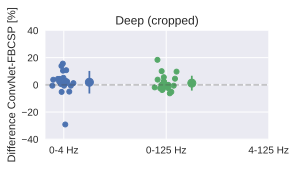

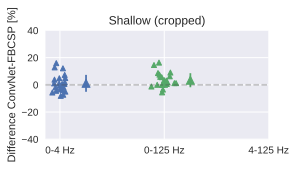

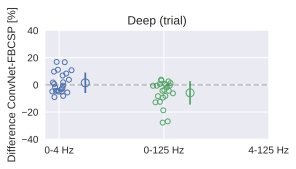

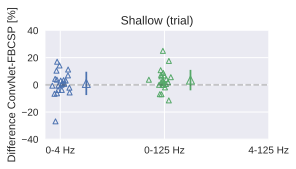

In [29]:
from numpy.random import RandomState

param_keys = ['freq', 'net',  'train_type', 'clean', 'max_abs_threshold']
all_groups = all_df.groupby(param_keys)

all_test_net = []
all_test_csp = []
rng = RandomState(394834)
for wanted_train_type in ('cnt', 'epo'):
    for wanted_net in ('deep5', 'shallow'):
        plt.figure(figsize=(4,2))
        
        offset = 0
        for name, group in all_groups:
            assert len(group['freq'].unique()) == 1
            freq = group['freq'].iloc[0]
            assert len(group['net'].unique()) == 1
            net = group['net'].iloc[0]
            assert len(group['clean'].unique()) == 1
            clean = group['clean'].iloc[0]
            assert len(group['train_type'].unique()) == 1
            train_type = group['train_type'].iloc[0]
            if clean == False: continue
            if net == 'csp': continue
            if net != wanted_net: continue
            if train_type != wanted_train_type: continue
            csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                        (all_df.clean == clean)]
            assert (len(csp) == 29 and not clean) or (len(csp) == 23 and clean)
            df_merged = group.merge(csp, on='dataset_filename', suffixes=('_net','_csp'))

            test_acc_net = np.array(df_merged['test_net'])
            test_acc_csp = np.array(df_merged['test_csp'])
            all_test_net.append(test_acc_net)
            all_test_csp.append(test_acc_csp)
            diffs = test_acc_net - test_acc_csp
            if net == 'deep5':
                marker = 'o'
            else:
                assert net == 'shallow'
                marker = '^'
            if '>0' == freq:
                color = seaborn.color_palette()[0]
            elif '>4' == freq:
                color = seaborn.color_palette()[1]
            else:
                assert freq == '0-4'
                color = seaborn.color_palette()[3]
            markerfacecolor = 'None'
            if 'cnt' == train_type:
                markerfacecolor = color

            plt.plot(
                    rng.randn(len(diffs)) * 0.05 + offset,
                        diffs, color=color, marker=marker, alpha=0.5, linestyle='None',
                    markersize=5,markeredgecolor=color, markerfacecolor=markerfacecolor, 
                     markeredgewidth=1)
            plt.errorbar(offset+0.25, np.mean(diffs), yerr=np.std(diffs), ecolor=color,
                     marker=marker, linestyle='None',
                markersize=8,markeredgecolor=color, markerfacecolor=markerfacecolor, 
                             markeredgewidth=1)
            offset += 1
            #plt.xlabel('FBCSP Accuracy [%]')
        plt.ylabel('Difference ConvNet-FBCSP [%]')
        plt.ylim(-40,40)
        plt.axhline(y=0, linestyle='--', color=(0.3,0.3,0.3,0.3))
        plt.xticks(range(0,3), ['0-4 Hz', '0-125 Hz', '4-125 Hz'])
        title_str = wanted_net.strip('5').capitalize()
        if wanted_train_type == 'cnt':
            title_str += " (cropped)"
        else:
            assert wanted_train_type == 'epo'
            title_str += " (trial)"
        plt.title(title_str)


### Single Subject All Dots CSP vs Nets

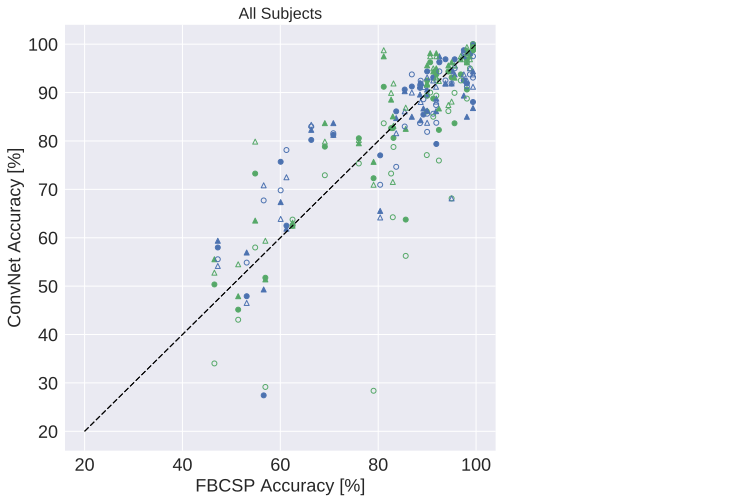

In [30]:
from numpy.random import RandomState

param_keys = ['freq', 'net',  'train_type', 'clean']
all_groups = all_df.groupby(param_keys)

all_test_net = []
all_test_csp = []
rng = RandomState(394834)
plt.figure(figsize=(7,7))
for wanted_train_type in ('cnt', 'epo'):
    for wanted_net in ('deep5', 'shallow'):
        
        offset = 0
        for name, group in all_groups:
            assert len(group['freq'].unique()) == 1
            freq = group['freq'].iloc[0]
            assert len(group['net'].unique()) == 1
            net = group['net'].iloc[0]
            assert len(group['clean'].unique()) == 1
            clean = group['clean'].iloc[0]
            assert len(group['train_type'].unique()) == 1
            train_type = group['train_type'].iloc[0]
            if clean == True: continue
            if net == 'csp': continue
            if net != wanted_net: continue
            if train_type != wanted_train_type: continue
            csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                        (all_df.clean == clean)]
            assert (len(csp) == 29 and not clean) or (len(csp) == 23 and clean)
            df_merged = group.merge(csp, on='dataset_filename', suffixes=('_net','_csp'))

            test_acc_net = np.array(df_merged['test_net'])
            test_acc_csp = np.array(df_merged['test_csp'])
            all_test_net.append(test_acc_net)
            all_test_csp.append(test_acc_csp)
            diffs = test_acc_net - test_acc_csp
            if net == 'deep5':
                marker = 'o'
            else:
                assert net == 'shallow'
                marker = '^'
            if '>0' == freq:
                color = seaborn.color_palette()[0]
            elif '>4' == freq:
                color = seaborn.color_palette()[1]
            else:
                assert freq == '0-4'
                color = seaborn.color_palette()[3]
            markerfacecolor = 'None'
            if 'cnt' == train_type:
                markerfacecolor = color

            plt.plot(
                    test_acc_csp, test_acc_net, color=color, marker=marker, alpha=0.5, linestyle='None',
                    markersize=5,markeredgecolor=color, markerfacecolor=markerfacecolor, 
                     markeredgewidth=1)
            #plt.xlabel('FBCSP Accuracy [%]')


    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[12:30], (
                               'Deep 0-4 Hz (cropped)', 
                               'Deep 0-4 Hz (trial)',
                               'Shallow 0-4 Hz (cropped)',
                               'Shallow 0-4 Hz (trial)',
                               'Deep 0-125 Hz (cropped)', 
                               'Deep 0-125 Hz (trial)',
                               'Shallow 0-125 Hz (cropped)',
                               'Shallow 0-125 Hz (trial)',
                               'Deep 4-125 Hz (cropped)', 
                               'Deep 4-125 Hz (trial)',
                               'Shallow 4-125 Hz (cropped)',
                               'Shallow 4-125 Hz (trial)',),
              bbox_to_anchor=(1.55,1),fontsize=14)

    plt.tight_layout()
    plt.xlabel('FBCSP Accuracy [%]', fontsize=18)

    plt.ylabel('ConvNet Accuracy [%]', fontsize=18)

    # We change the fontsize of minor ticks label 
    plt.gca().tick_params(axis='both', which='major', labelsize=18)
    plt.title('All Subjects', fontsize=16)
    plt.plot([20,100], [20,100], color='black', label='', linestyle='--', lw=1)

### add combined set comparison

In [31]:

param_keys = ['freq', 'net',  'train_type', 'clean']
all_groups = all_df.groupby(param_keys)

for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    assert len(group['clean'].unique()) == 1
    clean = group['clean'].iloc[0]
    assert len(group['train_type'].unique()) == 1
    train_type = group['train_type'].iloc[0]
    if net == 'csp': continue
    #if net != 'merged': continue
    log.info("{:s} {:s} {:s} (clean: {:s})".format(freq,net, train_type, str(clean)))
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                (all_df.clean == clean)]
    assert (len(csp) == 29 and not clean) or (len(csp) == 23 and clean)
    df_compare = compare_net_csp(group, csp, net, freq, 'combined', with_csp_acc=True, with_std=True,
                                with_std_error=True)
    df_compare['clean'] = clean
    df_compare['train_type'] = train_type
    all_compared = all_compared.append(df_compare)

INFO:root:>0 deep5 cnt (clean: False)
INFO:root:>0 deep5 cnt (clean: True)
INFO:root:>0 deep5 epo (clean: False)
INFO:root:>0 deep5 epo (clean: True)
INFO:root:>0 merged cnt (clean: False)
INFO:root:>0 merged cnt (clean: True)
INFO:root:>0 merged epo (clean: False)
INFO:root:>0 merged epo (clean: True)
INFO:root:>0 shallow cnt (clean: False)
INFO:root:>0 shallow cnt (clean: True)
INFO:root:>0 shallow epo (clean: False)
INFO:root:>0 shallow epo (clean: True)
INFO:root:>4 deep5 cnt (clean: False)
INFO:root:>4 deep5 cnt (clean: True)
INFO:root:>4 deep5 epo (clean: False)
INFO:root:>4 deep5 epo (clean: True)
INFO:root:>4 merged cnt (clean: False)
INFO:root:>4 merged cnt (clean: True)
INFO:root:>4 merged epo (clean: False)
INFO:root:>4 merged epo (clean: True)
INFO:root:>4 shallow cnt (clean: False)
INFO:root:>4 shallow cnt (clean: True)
INFO:root:>4 shallow epo (clean: False)
INFO:root:>4 shallow epo (clean: True)


In [32]:
all_compared[(all_compared.dataset == 'combined') & 
             (all_compared.clean ==False) & (all_compared.freq != '0-4')].sort_values(by='wilc')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,wilc,sign,time_net,clean,train_type
0,merged,>4,combined,83.6,68.7,-14.9,14.7,2.7,7.078052e-08,1.117587e-07,00:27:58,False,epo
0,deep5,>4,combined,83.6,75.0,-8.6,12.0,2.2,9.822473e-05,2.315700e-03,00:19:58,False,epo
0,shallow,>4,combined,83.6,86.2,2.6,7.1,1.3,2.906404e-02,2.411954e-02,00:16:56,False,epo
0,shallow,>4,combined,83.6,85.9,2.2,5.3,1.0,5.622556e-02,1.360459e-01,00:32:34,False,cnt
0,merged,>0,combined,84.2,82.7,-1.5,6.7,1.2,1.055598e-01,2.411954e-02,00:23:30,False,epo
0,deep5,>4,combined,83.6,82.7,-1.0,7.3,1.3,3.041932e-01,1.360459e-01,00:46:06,False,cnt
0,shallow,>0,combined,84.2,83.4,-0.8,7.1,1.3,3.926539e-01,4.582583e-01,00:27:38,False,cnt
0,deep5,>0,combined,84.2,84.5,0.3,8.4,1.6,4.169197e-01,2.649309e-01,00:48:50,False,cnt
0,merged,>4,combined,83.6,82.9,-0.7,6.2,1.1,5.792817e-01,4.582583e-01,00:54:16,False,cnt
0,deep5,>0,combined,84.2,84.2,0.0,7.4,1.4,7.013288e-01,2.649309e-01,00:18:25,False,epo


In [33]:
all_compared[(all_compared.dataset == 'combined') & 
             (all_compared.clean ==False) & (all_compared.freq != '0-4') &
            (all_compared.name == 'merged')].sort_values(by='wilc')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,wilc,sign,time_net,clean,train_type
0,merged,>4,combined,83.6,68.7,-14.9,14.7,2.7,7.078052e-08,1.117587e-07,00:27:58,False,epo
0,merged,>0,combined,84.2,82.7,-1.5,6.7,1.2,1.055598e-01,2.411954e-02,00:23:30,False,epo
0,merged,>4,combined,83.6,82.9,-0.7,6.2,1.1,5.792817e-01,4.582583e-01,00:54:16,False,cnt
0,merged,>0,combined,84.2,84.6,0.5,6.0,1.1,9.660341e-01,4.582583e-01,00:52:21,False,cnt


In [34]:
all_compared[(all_compared.dataset == 'combined') & 
             (all_compared.clean ==True) & (all_compared.freq != '0-4') &
            (all_compared.name == 'merged')].sort_values(by='wilc')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,wilc,sign,time_net,clean,train_type
0,merged,>4,combined,81.9,68.1,-13.8,15.4,3.2,0.000005,0.000006,00:26:36,True,epo
0,merged,>0,combined,82.1,81.4,-0.6,7.2,1.5,0.410040,0.093140,00:21:28,True,epo
0,merged,>0,combined,82.1,83.8,1.8,5.6,1.2,0.427418,1.000000,00:46:19,True,cnt
0,merged,>4,combined,81.9,82.1,0.3,6.0,1.2,0.799773,1.000000,00:48:40,True,cnt


In [35]:
all_compared[(all_compared.dataset == 'combined') & 
             (all_compared.clean ==True) & (all_compared.freq != '0-4')].sort_values(by='wilc')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,wilc,sign,time_net,clean,train_type
0,merged,>4,combined,81.9,68.1,-13.8,15.4,3.2,0.000005,0.000006,00:26:36,True,epo
0,shallow,>4,combined,81.9,85.2,3.4,5.2,1.1,0.002136,0.010622,00:26:43,True,cnt
0,deep5,>4,combined,81.9,76.0,-5.9,8.7,1.8,0.003874,0.034690,00:18:44,True,epo
0,deep5,>0,combined,82.1,84.0,1.9,8.3,1.7,0.023325,0.034690,00:42:23,True,cnt
0,shallow,>4,combined,81.9,85.3,3.5,7.5,1.6,0.023325,0.034690,00:12:35,True,epo
0,shallow,>0,combined,82.1,83.1,1.1,8.6,1.8,0.393073,0.677639,00:12:12,True,epo
0,merged,>0,combined,82.1,81.4,-0.6,7.2,1.5,0.410040,0.093140,00:21:28,True,epo
0,merged,>0,combined,82.1,83.8,1.8,5.6,1.2,0.427418,1.000000,00:46:19,True,cnt
0,deep5,>0,combined,82.1,83.6,1.5,7.5,1.6,0.643390,1.000000,00:17:09,True,epo
0,shallow,>0,combined,82.1,83.2,1.1,6.2,1.3,0.709014,1.000000,00:22:16,True,cnt


In [36]:
all_compared[(all_compared.train_type == 'cnt') &
            (all_compared.dataset == 'combined') &
            (all_compared.freq != '0-4') &
            (all_compared.clean == False)].sort_values(by='name')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,wilc,sign,time_net,clean,train_type
0,deep5,>0,combined,84.2,84.5,0.3,8.4,1.6,0.416920,0.264931,00:48:50,False,cnt
0,deep5,>4,combined,83.6,82.7,-1.0,7.3,1.3,0.304193,0.136046,00:46:06,False,cnt
0,merged,>0,combined,84.2,84.6,0.5,6.0,1.1,0.966034,0.458258,00:52:21,False,cnt
0,merged,>4,combined,83.6,82.9,-0.7,6.2,1.1,0.579282,0.458258,00:54:16,False,cnt
0,shallow,>0,combined,84.2,83.4,-0.8,7.1,1.3,0.392654,0.458258,00:27:38,False,cnt
0,shallow,>4,combined,83.6,85.9,2.2,5.3,1.0,0.056226,0.136046,00:32:34,False,cnt


In [37]:
all_compared[(all_compared.train_type == 'cnt') &
            (all_compared.dataset == 'combined') &
            (all_compared.freq != '0-4') &
            (all_compared.clean == True)].sort_values(by='name')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,wilc,sign,time_net,clean,train_type
0,deep5,>0,combined,82.1,84.0,1.9,8.3,1.7,0.023325,0.034690,00:42:23,True,cnt
0,deep5,>4,combined,81.9,83.1,1.2,5.5,1.1,0.893212,0.404873,00:39:43,True,cnt
0,merged,>0,combined,82.1,83.8,1.8,5.6,1.2,0.427418,1.000000,00:46:19,True,cnt
0,merged,>4,combined,81.9,82.1,0.3,6.0,1.2,0.799773,1.000000,00:48:40,True,cnt
0,shallow,>0,combined,82.1,83.2,1.1,6.2,1.3,0.709014,1.000000,00:22:16,True,cnt
0,shallow,>4,combined,81.9,85.2,3.4,5.2,1.1,0.002136,0.010622,00:26:43,True,cnt


In [38]:
all_compared[(all_compared.name != 'merged') &
            (all_compared.freq != '0-4') &
            (all_compared.clean == True) &
            (all_compared.train_type == 'cnt')].sort_values(
    by='name', kind='mergesort').sort_values(by='freq', kind='mergesort').sort_values(by='dataset', kind='mergesort')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,wilc,sign,time_net,clean,train_type
0,deep5,>0,bcic,68.0,70.9,2.9,12.9,4.3,0.250000,0.179688,00:29:07,True,cnt
0,shallow,>0,bcic,68.0,73.7,5.7,6.8,2.3,0.039062,0.039062,00:15:32,True,cnt
0,deep5,>4,bcic,67.8,70.1,2.3,7.5,2.5,0.734375,1.000000,00:27:07,True,cnt
0,shallow,>4,bcic,67.8,71.9,4.1,6.0,2.0,0.097656,0.179688,00:17:18,True,cnt
0,deep5,>0,combined,82.1,84.0,1.9,8.3,1.7,0.023325,0.034690,00:42:23,True,cnt
0,shallow,>0,combined,82.1,83.2,1.1,6.2,1.3,0.709014,1.000000,00:22:16,True,cnt
0,deep5,>4,combined,81.9,83.1,1.2,5.5,1.1,0.893212,0.404873,00:39:43,True,cnt
0,shallow,>4,combined,81.9,85.2,3.4,5.2,1.1,0.002136,0.010622,00:26:43,True,cnt
0,deep5,>0,ours,91.2,92.4,1.3,2.4,0.6,0.057983,0.179565,00:50:54,True,cnt
0,shallow,>0,ours,91.2,89.3,-1.9,3.3,0.9,0.078491,0.179565,00:26:35,True,cnt


In [39]:
all_compared[(all_compared.name != 'merged') &
            (all_compared.freq != '0-4') &
            (all_compared.clean == True)].sort_values(by='train_type', kind='mergesort').sort_values(
    by='name', kind='mergesort').sort_values(by='freq', kind='mergesort').sort_values(by='dataset', kind='mergesort')

,name,freq,dataset,test_csp,test_net,diff,std,stderr,wilc,sign,time_net,clean,train_type
0,deep5,>0,bcic,68.0,70.9,2.9,12.9,4.3,0.250000,0.179688,00:29:07,True,cnt
0,deep5,>0,bcic,68.0,72.6,4.7,8.2,2.7,0.164062,0.507812,00:06:54,True,epo
0,shallow,>0,bcic,68.0,73.7,5.7,6.8,2.3,0.039062,0.039062,00:15:32,True,cnt
0,shallow,>0,bcic,68.0,73.3,5.3,7.2,2.4,0.074219,0.179688,00:06:05,True,epo
0,deep5,>4,bcic,67.8,70.1,2.3,7.5,2.5,0.734375,1.000000,00:27:07,True,cnt
0,deep5,>4,bcic,67.8,58.6,-9.3,9.7,3.2,0.039062,0.179688,00:06:43,True,epo
0,shallow,>4,bcic,67.8,71.9,4.1,6.0,2.0,0.097656,0.179688,00:17:18,True,cnt
0,shallow,>4,bcic,67.8,73.3,5.5,9.0,3.0,0.097656,0.039062,00:05:14,True,epo
0,deep5,>0,combined,82.1,84.0,1.9,8.3,1.7,0.023325,0.034690,00:42:23,True,cnt
0,deep5,>0,combined,82.1,83.6,1.5,7.5,1.6,0.643390,1.000000,00:17:09,True,epo


In [40]:
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

### plot with only one variant but all dots as scatter stuffs

In [41]:
all_compared[(all_compared.dataset == 'combined') &
                                       (all_compared.train_type == 'cnt')]

,name,freq,dataset,test_csp,test_net,diff,std,stderr,wilc,sign,time_net,clean,train_type
0,deep5,>0,combined,84.2,84.5,0.3,8.4,1.6,0.416920,0.264931,00:48:50,False,cnt
0,deep5,>0,combined,82.1,84.0,1.9,8.3,1.7,0.023325,0.034690,00:42:23,True,cnt
0,merged,>0,combined,84.2,84.6,0.5,6.0,1.1,0.966034,0.458258,00:52:21,False,cnt
0,merged,>0,combined,82.1,83.8,1.8,5.6,1.2,0.427418,1.000000,00:46:19,True,cnt
0,shallow,>0,combined,84.2,83.4,-0.8,7.1,1.3,0.392654,0.458258,00:27:38,False,cnt
0,shallow,>0,combined,82.1,83.2,1.1,6.2,1.3,0.709014,1.000000,00:22:16,True,cnt
0,deep5,>4,combined,83.6,82.7,-1.0,7.3,1.3,0.304193,0.136046,00:46:06,False,cnt
0,deep5,>4,combined,81.9,83.1,1.2,5.5,1.1,0.893212,0.404873,00:39:43,True,cnt
0,merged,>4,combined,83.6,82.9,-0.7,6.2,1.1,0.579282,0.458258,00:54:16,False,cnt
0,merged,>4,combined,81.9,82.1,0.3,6.0,1.2,0.799773,1.000000,00:48:40,True,cnt


In [42]:
all_compared.to_csv('data/paper/p-values/all_compared.csv')

### With column/row labels

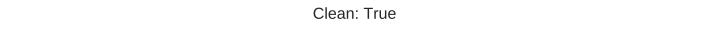

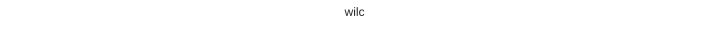

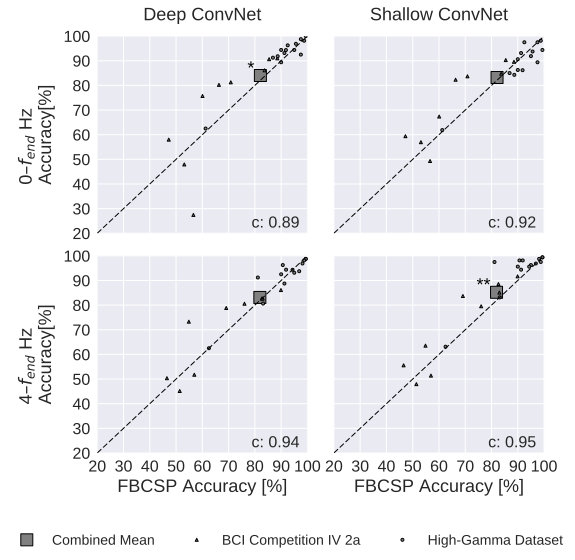

In [43]:
%config InlineBackend.figure_format = 'svg'
for_eps = False
alpha=0.4

all_labels = []
for clean in (True,) : #False
    plt.figure(figsize=(12,0.1))
    plt.title("Clean: " + str(clean), fontsize=16)
    plt.axis('off')
    for stat_test in ('wilc', ):#'sign','rand',
        plt.figure(figsize=(12,0.1))
        plt.title(stat_test)
        plt.axis('off')
        fig, axes = plt.subplots(2,2,figsize=(7,7), sharex=True, sharey=True)
        axes = np.array(axes).flatten()
        i_plot = 0
        for freq in ('>0', '>4'):
            for net in ('deep5', 'shallow'):
                for train_type in ('cnt',):
                    for dataset in ('combined',):#, 'ours', 'bcic'
                        this_row = all_compared[(all_compared.dataset == dataset) &
                                               (all_compared.freq == freq) &
                                               (all_compared.train_type == train_type) &
                                               (all_compared.name == net) &
                                                (all_compared.clean == clean)]
                        if net == 'merged' and freq == '0-4': continue
                        assert len(this_row) == 1
                        this_row = this_row.iloc[0]
                        if net == 'deep5':
                            marker = 'o'
                        elif net == 'merged':
                            marker = 's'
                        else:
                            assert net == 'shallow'
                            marker = '^'
                        if dataset == 'bcic':
                            marker = '^'
                        elif dataset == 'ours':
                            marker = 'o'
                        if '>0' == freq:
                            color = seaborn.color_palette()[0]
                        elif '>4' == freq:
                            color = seaborn.color_palette()[1]
                        else:
                            assert freq == '0-4'
                            color = seaborn.color_palette()[3]
                        color=(0.5,0.5,0.5)
                        markerfacecolor = 'None'
                        markersize=10
                        if train_type == 'epo':
                            markersize=17

                        markerfacecolor = 'None'
                        markeredgecolor = color
                        if 'cnt' == train_type:
                            markerfacecolor = color
                            markeredgecolor = (0,0,0)#'black'

                        test_csp = this_row['test_csp']
                        test_net = this_row['test_net']
                        plt.sca(axes[i_plot])
                        i_plot += 1
                        
                        if dataset == 'combined':
                            plt.plot(test_csp, test_net, color=color, 
                                 marker='s', linestyle='None', markersize=markersize+2, label='dummy',
                                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                                markeredgewidth=1)
                        else:
                            plt.plot(test_csp, test_net, color=color, 
                                 marker=marker, linestyle='None', markersize=markersize, label='dummy',
                                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                                markeredgewidth=1)

                        # add significance star
                        if this_row[stat_test] < 0.05:
                            if this_row[stat_test] < 0.001:
                                signicance_str = '***'
                                sig_count_strong.append(int(np.sign(test_net - test_csp)))
                            elif this_row[stat_test] < 0.01:
                                signicance_str = '**'

                            else:
                                signicance_str = '*'
                            if test_csp < test_net:
                                xytext = (-6, -2)
                            else:
                                xytext = (3,-12)
                            plt.annotate(
                                signicance_str, xy = (test_csp, test_net), xytext = xytext, fontsize=18,
                                textcoords = 'offset points', ha = 'right', va = 'bottom',
                                color='black')
                        """
                        dataset_str = dataset.upper()[:4].replace("OURS", "HGD")

                        xytext=(-25,10)
                        if dataset == 'combined':
                            xytext = (-25,5)
                        plt.annotate(dataset_str,xy=(test_csp, test_net), xytext=xytext,
                                     textcoords='offset points', va='center',
                                ha='right', fontsize=14, color=(0.3,)*3,
                            arrowprops=dict(arrowstyle="->", color=(0.,)*3))
                        """
                        if dataset == 'combined':
                            df_net = all_df[
                                   (all_df.freq == freq) &
                                   (all_df.train_type == train_type) &
                                   (all_df.net == net) &
                                    (all_df.clean == clean)]

                            df_csp = all_df[
                                   (all_df.freq == freq) &
                                   (all_df.net == 'csp') &
                                    (all_df.clean == clean)]

                            df_merged = df_net.merge(df_csp, on='dataset_filename', suffixes=('_net','_csp'))
                            test_per_sub_csp_bcic = df_merged[df_merged.dataset_net == 'bcic'].test_csp
                            test_per_sub_csp_ours = df_merged[df_merged.dataset_net == 'ours'].test_csp
                            test_per_sub_net_bcic = df_merged[df_merged.dataset_net == 'bcic'].test_net
                            test_per_sub_net_ours = df_merged[df_merged.dataset_net == 'ours'].test_net
                            
                            if for_eps:
                                bgcolor = np.array((234/255.0, 234/255.0, 242/255.0))
                                markerfacecolor = np.array(markerfacecolor) * alpha + ((1-alpha) * bgcolor)
                                markeredgecolor = np.array(markeredgecolor) * alpha + ((1-alpha) * bgcolor)
                                color = np.array(color) * alpha + ((1-alpha) * bgcolor)
                                disp_alpha = 1
                            else:
                                disp_alpha = alpha
                            
                            plt.plot(test_per_sub_csp_bcic, test_per_sub_net_bcic, color=color, 
                                 marker='^', linestyle='None', markersize=3, label='dummy',
                                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                                markeredgewidth=1, alpha=disp_alpha)
                            plt.plot(test_per_sub_csp_ours, test_per_sub_net_ours, color=color, 
                                 marker='o', linestyle='None', markersize=3, label='dummy',
                                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                                markeredgewidth=1, alpha=disp_alpha)
                            test_per_sub_csp = np.concatenate([test_per_sub_csp_bcic, test_per_sub_csp_ours])
                            test_per_sub_net = np.concatenate([test_per_sub_net_bcic, test_per_sub_net_ours])
                            correlation = np.corrcoef(test_per_sub_csp, test_per_sub_net)[0,1]
                            n_above = np.sum(test_per_sub_net > test_per_sub_csp)
                            n_below = np.sum(test_per_sub_net < test_per_sub_csp)


                #min_x_y = min(plt.xlim()[0], plt.ylim()[0])
                #max_x_y = max(plt.xlim()[1], plt.ylim()[1])
                #plt.plot([min_x_y-5,max_x_y+5], [min_x_y-5,max_x_y+5], color='black', label='', linestyle='--', lw=1)
                plt.plot([20,100], [20,100], color='black', label='', linestyle='--', lw=1)
                
                
                if i_plot > 2:
                    plt.xlabel('FBCSP Accuracy [%]', fontsize=18)
                if i_plot <= 2:
                    net_str = net.capitalize().replace("5", "")
                    title_str = "{:s} ConvNet".format(net_str)
                    plt.title(title_str, fontsize=18, y=1.05)
                
                if i_plot % 2 == 1:
                    y_label_str = u'{:d}–$f_{{end}}$ Hz\nAccuracy[%]'.format(int(freq[1]))
                    #plt.ylabel(y_label_str, fontsize=18)
                    plt.text(-10,60,y_label_str, va='center', rotation=90,
                            fontsize=18)

                ax = plt.gca()

                plt.tight_layout()
                plt.annotate(u"c: {:.2f}".format(correlation),xy=(97,24),
                            fontsize=16, ha='right', va='center')


                plt.xlim(20,100)
                plt.ylim(20,100)
                plt.xticks(range(20,101,10))
                plt.yticks(range(20,101,10))
                # We change the fontsize of minor ticks label 
                plt.gca().tick_params(axis='both', which='major', labelsize=16)

        
        ax = plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        leg = ax.legend(np.array(handles), ["Combined Mean", "BCI Competition IV 2a", "High-Gamma Dataset", ], 
                  bbox_to_anchor=(1.15,-.35), fontsize=14, ncol=3)
        #http://stackoverflow.com/a/35200637/1469195
        # not wroking like this, but could be adapted
        #for l in leg.get_lines():
        #    l.set_alpha(1)
        #    l.set_marker('.')
        
plt.savefig('Final_Comparison.ipynb.2.pdf', bbox_inches='tight', dpi=600)
plt.savefig('Final_Comparison.ipynb.2.eps', bbox_inches='tight', dpi=600)

#### for merged net

###### significance tests hybrid vs deep and retests of main result with different significance tests

In [44]:
all_compared[(all_compared.dataset == 'bcic') & 
            (all_compared.clean == True) &
            (all_compared.train_type =='cnt')& 
            (all_compared.name == 'merged') ]

,name,freq,dataset,test_csp,test_net,diff,std,stderr,wilc,sign,time_net,clean,train_type
0,merged,>0,bcic,68.0,71.6,3.6,7.9,2.6,0.359375,1.0,00:29:26,True,cnt
0,merged,>4,bcic,67.8,66.2,-1.6,7.5,2.5,0.652344,1.0,00:28:35,True,cnt


In [45]:
deep_above_0 = all_df[(all_df.freq == '>0') &
                           (all_df.train_type == 'cnt')& 
                           (all_df.net == 'deep5') &
                           (all_df.clean == True)]
deep_above_4 = all_df[(all_df.freq == '>4') &
                           (all_df.train_type == 'cnt')& 
                           (all_df.net == 'deep5') &
                           (all_df.clean == True)]
csp_acc_above_0 = all_df[(all_df.freq == '>0') &
                           (all_df.train_type == 'epo')& 
                           (all_df.net == 'csp') &
                           (all_df.clean == True)]
csp_acc_above_4 = all_df[(all_df.freq == '>4') &
                           (all_df.train_type == 'epo')& 
                           (all_df.net == 'csp') &
                           (all_df.clean == True)]
merged_above_0 = all_df[(all_df.freq == '>0') &
                           (all_df.train_type == 'cnt')& 
                           (all_df.net == 'merged') &
                           (all_df.clean == True)]
merged_above_4 = all_df[(all_df.freq == '>4') &
                           (all_df.train_type == 'cnt')& 
                           (all_df.net == 'merged') &
                           (all_df.clean == True)]

In [46]:
deep_vs_csp_0 = csp_acc_above_0.merge(deep_above_0, on=('dataset_filename', 'freq'))
assert len(deep_vs_csp_0) == 23

In [47]:
deep_vs_csp_4 = csp_acc_above_4.merge(deep_above_4, on=('dataset_filename', 'freq'))
assert len(deep_vs_csp_4) == 23

In [48]:
wilcoxon_signed_rank(deep_vs_csp_0.test_x, deep_vs_csp_0.test_y)

0.023324728012084961

In [49]:
from scipy import stats

In [50]:
stats.wilcoxon(deep_vs_csp_0.test_x, deep_vs_csp_0.test_y, zero_method='zsplit')

WilcoxonResult(statistic=63.5, pvalue=0.023352436044260946)

In [51]:
compare_net_csp(deep_above_0, merged_above_0, '','','', with_csp_acc=True,
               max_n_p_vals=2)

,name,freq,dataset,test_csp,test_net,diff,wilc,sign,time_net
0,,,,83.8,84.0,0.2,0.559958,0.677639,00:42:23


In [52]:
compare_net_csp(deep_above_4, merged_above_4, '','','', with_csp_acc=True,
               max_n_p_vals=2)

,name,freq,dataset,test_csp,test_net,diff,wilc,sign,time_net
0,,,,82.1,83.1,1.0,0.916847,0.677639,00:39:43


## Without ELU/Bnorm/Drop

In [53]:
all_df_past = pd.DataFrame()
for dataset in ('bcic', 'ours'):
    for net in 'shallow', 'deep5':
        for training in 'epo', 'cnt':
            for band in ['>0', '>4']:
                for clean in (True, False):
                    if dataset == 'bcic':
                        dfc = df_csp_bcic
                    else:
                        assert dataset == 'ours'
                        dfc = df_csp_ours
                    if dataset == 'bcic' and net == 'shallow' and training == 'cnt':
                        dfn = df_shallow_cnt_bcic
                    elif dataset == 'bcic' and net == 'shallow' and training == 'epo':
                        dfn = df_shallow_epo_bcic
                    elif dataset == 'bcic' and net == 'deep5' and training == 'cnt':
                        dfn = df_deep_cnt_bcic
                    elif dataset == 'bcic' and net == 'deep5' and training == 'epo':
                        dfn = df_deep_epo_bcic
                    elif dataset == 'ours' and net == 'shallow' and training == 'cnt':
                        dfn = df_shallow_cnt_ours
                    elif dataset == 'ours' and net == 'shallow' and training == 'epo':
                        dfn = df_shallow_epo_ours
                    elif dataset == 'ours' and net == 'deep5' and training == 'cnt':
                        dfn = df_deep_cnt_ours
                    elif dataset == 'ours' and net == 'deep5' and training == 'epo':
                        dfn = df_deep_epo_ours
                    else:
                        raise ValueError("Unknown combination")
                    if clean:
                        dfn = clean_datasets(dfn)
                        dfc = clean_datasets(dfc)
                    
                    dfn = past(dfn)
                        
                    if band == '>0':
                        this_dfn = above_0(dfn)
                        this_dfc = csp_above_0(dfc)
                    elif band == '>4':
                        this_dfn = above_4(dfn)
                        this_dfc = csp_above_4(dfc)
                    elif band == '0-4':
                        this_dfn = from_0_to_4(dfn)
                        this_dfc = csp_0_to_4(dfc)
                        
                    if training == 'cnt':
                        this_dfn = tied_loss(this_dfn)
                        
                    this_dfc = main_comp_csp(this_dfc)
                    
                    this_dfc = this_dfc[this_dfc.trial_start == 500]
                    if training == 'epo':
                        this_dfn = this_dfn[this_dfn.trial_start == -500]
                    else:
                        assert training == 'cnt'
                        this_dfn = this_dfn[this_dfn.trial_start == 1500]
                        
                    this_dfc = restrict_or_missing_col(this_dfc, max_abs_threshold=800)
                    
                    if dataset == 'bcic' and net == 'deep5' and (
                        training == 'epo' or (band == '>0' or band == '>4')):
                        this_dfn = this_dfn[this_dfn.layers == 'deep_5']
                    if training == 'epo':
                        this_dfn = this_dfn[this_dfn.max_increasing_epochs == 160]
                    else:
                        assert training == 'cnt'
                        this_dfn = this_dfn[this_dfn.max_increasing_epochs == 80]

                    if dataset == 'bcic':
                        assert len(this_dfc) == 9, "wrong length: {:d} ({:s})".format(
                            len(this_dfc), str((dataset, net, training, band, clean)))
                        assert len(this_dfn) == 9, "wrong length: {:d} ({:s})".format(
                            len(this_dfn), str((dataset, net, training, band, clean)))
                    elif dataset == 'ours' and clean:
                        assert len(this_dfc) == 14, "wrong length: {:d} ({:s})".format(
                            len(this_dfc), str((dataset, net, training, band, clean)))
                        assert len(this_dfn) == 14, "wrong length: {:d} ({:s})".format(
                            len(this_dfn), str((dataset, net, training, band, clean)))
                    elif dataset == 'ours' and (not clean):
                        assert len(this_dfc) == 20, "wrong length: {:d} ({:s})".format(
                            len(this_dfc), str((dataset, net, training, band, clean)))
                        assert len(this_dfn) == 20, "wrong length: {:d} ({:s})".format(
                            len(this_dfn), str((dataset, net, training, band, clean)))
                    else:
                        raise ValueError("Unknown combination")

                
                    this_dfn = remove_columns_with_same_value(this_dfn)
                    this_dfn['clean'] = clean
                    this_dfn['net'] = net
                    this_dfn['train_type'] = training
                    this_dfn['freq'] = band
                    this_dfn['dataset'] = dataset

                    all_df_past = all_df_past.append(this_dfn)
                    # no need to add csp... comparison csp stays same

In [54]:
assert len(all_df_past) == 8 * 29 +  8* 23 # no csp

In [55]:
all_compared_past = pd.DataFrame()
param_keys = ['dataset', 'freq', 'net',  'train_type', 'clean']
all_groups = all_df_past.groupby(param_keys)

for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    assert len(group['dataset'].unique()) == 1
    dataset = group['dataset'].iloc[0]
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    assert len(group['clean'].unique()) == 1
    clean = group['clean'].iloc[0]
    assert len(group['train_type'].unique()) == 1
    train_type = group['train_type'].iloc[0]
    if net == 'csp': continue
    log.info("{:s} {:s} {:s} {:s} (clean: {:s})".format(dataset,
                                                        freq,net, train_type, str(clean)))
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                (all_df.dataset == dataset) &
                (all_df.clean == clean)]
    df_compare = compare_net_csp(group, csp, net, freq, dataset, with_csp_acc=True, with_std=True,
                                with_std_error=True)   
    df_compare['clean'] = clean
    df_compare['train_type'] = train_type
    all_compared_past = all_compared_past.append(df_compare)


param_keys = ['freq', 'net',  'train_type', 'clean']
all_groups = all_df_past.groupby(param_keys)

for name, group in all_groups:
    assert len(group['freq'].unique()) == 1
    freq = group['freq'].iloc[0]
    assert len(group['net'].unique()) == 1
    net = group['net'].iloc[0]
    assert len(group['clean'].unique()) == 1
    clean = group['clean'].iloc[0]
    assert len(group['train_type'].unique()) == 1
    train_type = group['train_type'].iloc[0]
    if net == 'csp': continue
    log.info("combined: {:s} {:s} {:s} (clean: {:s})".format(freq,net, train_type, str(clean)))
    csp = all_df[(all_df.net == 'csp') & (all_df.freq == freq) &
                (all_df.clean == clean)]
    assert (len(csp) == 29 and not clean) or (len(csp) == 23 and clean)
    df_compare = compare_net_csp(group, csp, net, freq, 'combined', with_csp_acc=True, with_std=True,
                                with_std_error=True)
    df_compare['clean'] = clean
    df_compare['train_type'] = train_type
    all_compared_past = all_compared_past.append(df_compare)

INFO:root:bcic >0 deep5 cnt (clean: False)
INFO:root:bcic >0 deep5 cnt (clean: True)
INFO:root:bcic >0 deep5 epo (clean: False)
INFO:root:bcic >0 deep5 epo (clean: True)
INFO:root:bcic >0 shallow cnt (clean: False)
INFO:root:bcic >0 shallow cnt (clean: True)
INFO:root:bcic >0 shallow epo (clean: False)
INFO:root:bcic >0 shallow epo (clean: True)
INFO:root:bcic >4 deep5 cnt (clean: False)
INFO:root:bcic >4 deep5 cnt (clean: True)
INFO:root:bcic >4 deep5 epo (clean: False)
INFO:root:bcic >4 deep5 epo (clean: True)
INFO:root:bcic >4 shallow cnt (clean: False)
INFO:root:bcic >4 shallow cnt (clean: True)
INFO:root:bcic >4 shallow epo (clean: False)
INFO:root:bcic >4 shallow epo (clean: True)
INFO:root:ours >0 deep5 cnt (clean: False)
INFO:root:ours >0 deep5 cnt (clean: True)
INFO:root:ours >0 deep5 epo (clean: False)
INFO:root:ours >0 deep5 epo (clean: True)
INFO:root:ours >0 shallow cnt (clean: False)
INFO:root:ours >0 shallow cnt (clean: True)
INFO:root:ours >0 shallow epo (clean: False)


In [56]:
all_compared_past.to_csv('data/paper/p-values/all_compared_past.csv')

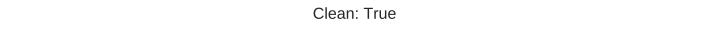

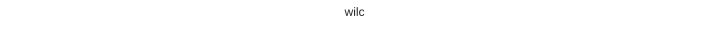

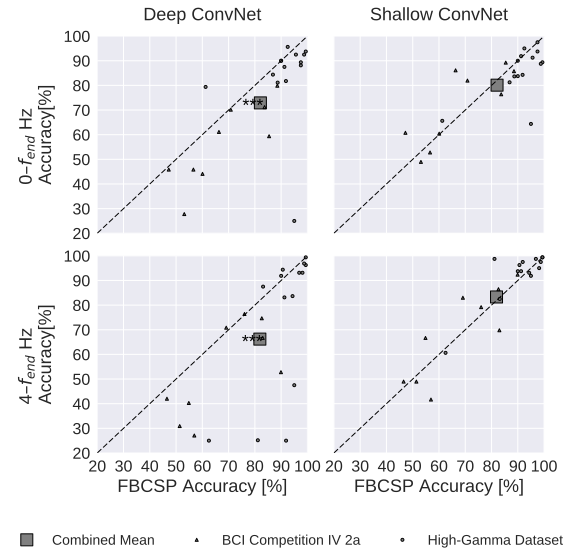

In [99]:
%config InlineBackend.figure_format = 'svg' 

all_labels = []
alpha = 0.4
for_eps = False
for clean in (True,) : #False
    plt.figure(figsize=(12,0.1))
    plt.title("Clean: " + str(clean), fontsize=16)
    plt.axis('off')
    for stat_test in ('wilc', ):#'sign','rand',
        plt.figure(figsize=(12,0.1))
        plt.title(stat_test)
        plt.axis('off')
        fig, axes = plt.subplots(2,2,figsize=(7,7), sharex=True, sharey=True)
        axes = np.array(axes).flatten()
        i_plot = 0
        for freq in ('>0', '>4'):
            for net in ('deep5', 'shallow'):
                for train_type in ('cnt',):
                    for dataset in ('combined',):#, 'ours', 'bcic'
                        this_row = all_compared_past[(all_compared_past.dataset == dataset) &
                                               (all_compared_past.freq == freq) &
                                               (all_compared_past.train_type == train_type) &
                                               (all_compared_past.name == net) &
                                                (all_compared_past.clean == clean)]
                        if net == 'merged' and freq == '0-4': continue
                        assert len(this_row) == 1
                        this_row = this_row.iloc[0]
                        if net == 'deep5':
                            marker = 'o'
                        elif net == 'merged':
                            marker = 's'
                        else:
                            assert net == 'shallow'
                            marker = '^'
                        if dataset == 'bcic':
                            marker = '^'
                        elif dataset == 'ours':
                            marker = 'o'
                        if '>0' == freq:
                            color = seaborn.color_palette()[0]
                        elif '>4' == freq:
                            color = seaborn.color_palette()[1]
                        else:
                            assert freq == '0-4'
                            color = seaborn.color_palette()[3]
                        color=(0.5,0.5,0.5)
                        markerfacecolor = 'None'
                        markersize=10
                        if train_type == 'epo':
                            markersize=17

                        markerfacecolor = 'None'
                        markeredgecolor = color
                        if 'cnt' == train_type:
                            markerfacecolor = color
                            markeredgecolor = (0,0,0)#'black'

                        test_csp = this_row['test_csp']
                        test_net = this_row['test_net']
                        plt.sca(axes[i_plot])
                        i_plot += 1
                        
                        if dataset == 'combined':
                            plt.plot(test_csp, test_net, color=color, 
                                 marker='s', linestyle='None', markersize=markersize+2, label='dummy',
                                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                                markeredgewidth=1)
                        else:
                            plt.plot(test_csp, test_net, color=color, 
                                 marker=marker, linestyle='None', markersize=markersize, label='dummy',
                                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                                markeredgewidth=1)

                        # add significance star
                        if this_row[stat_test] < 0.05:
                            if this_row[stat_test] < 0.001:
                                signicance_str = '***'
                                #sig_count_strong.append(int(np.sign(test_net - test_csp)))
                            elif this_row[stat_test] < 0.01:
                                signicance_str = '**'
                                #sig_count_strong.append(int(np.sign(test_net - test_csp)))

                            else:
                                signicance_str = '*'
                                sig_count_weak.append(int(np.sign(test_net - test_csp)))
                            if test_csp < test_net:
                                xytext = (-6, -2)
                            else:
                                xytext = (3,-12)
                            plt.annotate(
                                signicance_str, xy = (test_csp, test_net), xytext = xytext, fontsize=18,
                                textcoords = 'offset points', ha = 'right', va = 'bottom',
                                color='black')
                        if dataset == 'combined':
                            df_net = all_df_past[
                                   (all_df_past.freq == freq) &
                                   (all_df_past.train_type == train_type) &
                                   (all_df_past.net == net) &
                                    (all_df_past.clean == clean)]

                            df_csp = all_df[
                                   (all_df.freq == freq) &
                                   (all_df.net == 'csp') &
                                    (all_df.clean == clean)]

                            df_merged = df_net.merge(df_csp, on='dataset_filename', suffixes=('_net','_csp'))
                            test_per_sub_csp_bcic = df_merged[df_merged.dataset_net == 'bcic'].test_csp
                            test_per_sub_csp_ours = df_merged[df_merged.dataset_net == 'ours'].test_csp
                            test_per_sub_net_bcic = df_merged[df_merged.dataset_net == 'bcic'].test_net
                            test_per_sub_net_ours = df_merged[df_merged.dataset_net == 'ours'].test_net
                            
                            if for_eps:
                                bgcolor = np.array((234/255.0, 234/255.0, 242/255.0))
                                markerfacecolor = np.array(markerfacecolor) * alpha + ((1-alpha) * bgcolor)
                                markeredgecolor = np.array(markeredgecolor) * alpha + ((1-alpha) * bgcolor)
                                color = np.array(color) * alpha + ((1-alpha) * bgcolor)
                                disp_alpha = 1
                            else:
                                disp_alpha = alpha
                            
                            plt.plot(test_per_sub_csp_bcic, test_per_sub_net_bcic, color=color, 
                                 marker='^', linestyle='None', markersize=3, label='dummy',
                                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                                markeredgewidth=1, alpha=disp_alpha)
                            plt.plot(test_per_sub_csp_ours, test_per_sub_net_ours, color=color, 
                                 marker='o', linestyle='None', markersize=3, label='dummy',
                                markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor,
                                markeredgewidth=1, alpha=disp_alpha)
                            test_per_sub_csp = np.concatenate([test_per_sub_csp_bcic, test_per_sub_csp_ours])
                            test_per_sub_net = np.concatenate([test_per_sub_net_bcic, test_per_sub_net_ours])
                            correlation = np.corrcoef(test_per_sub_csp, test_per_sub_net)[0,1]
                            n_above = np.sum(test_per_sub_net > test_per_sub_csp)
                            n_below = np.sum(test_per_sub_net < test_per_sub_csp)


                #min_x_y = min(plt.xlim()[0], plt.ylim()[0])
                #max_x_y = max(plt.xlim()[1], plt.ylim()[1])
                #plt.plot([min_x_y-5,max_x_y+5], [min_x_y-5,max_x_y+5], color='black', label='', linestyle='--', lw=1)
                plt.plot([20,100], [20,100], color='black', label='', linestyle='--', lw=1)
                
                
                if i_plot > 2:
                    plt.xlabel('FBCSP Accuracy [%]', fontsize=18)
                if i_plot <= 2:
                    net_str = net.capitalize().replace("5", "")
                    title_str = "{:s} ConvNet".format(net_str)
                    plt.title(title_str, fontsize=18, y=1.05)
                
                if i_plot % 2 == 1:
                    y_label_str = u'{:d}–$f_{{end}}$ Hz\nAccuracy[%]'.format(int(freq[1]))
                    #plt.ylabel(y_label_str, fontsize=18)
                    plt.text(-10,60,y_label_str, va='center', rotation=90,
                            fontsize=18)

                ax = plt.gca()

                plt.tight_layout()
                #plt.annotate(u"c: {:.2f}".format(correlation),xy=(97,24),
                #            fontsize=16, ha='right', va='center')
                #plt.annotate(u"Above: {:d}".format(n_above),xy=(23,93),
                #            fontsize=16, ha='left')

                #plt.annotate(u"Below: {:d}".format(n_below),xy=(97,33),
                #            fontsize=16, ha='right')


                # We change the fontsize of minor ticks label 
                plt.xlim(20,100)
                plt.ylim(20,100)
                plt.xticks(range(20,101,10))
                plt.yticks(range(20,101,10))
                plt.gca().tick_params(axis='both', which='major', labelsize=16)


        ax = plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(np.array(handles), ["Combined Mean", "BCI Competition IV 2a", "High-Gamma Dataset", ], 
                  bbox_to_anchor=(1.15,-.35), fontsize=14, ncol=3)

plt.savefig('Final_Comparison.ipynb.6.pdf', bbox_inches='tight', dpi=600, pad_inches=0)
plt.savefig('Final_Comparison.ipynb.6.eps', bbox_inches='tight', dpi=600, pad_inches=0)
plt.savefig('Final_Comparison.ipynb.6.png', bbox_inches='tight', dpi=600, pad_inches=0)

##### for text look at p values

In [58]:
all_compared_past[(all_compared_past.dataset == 'combined') &
                                               (all_compared_past.train_type == 'cnt') &
                                                (all_compared_past.clean == True)]

,name,freq,dataset,test_csp,test_net,diff,std,stderr,wilc,sign,time_net,clean,train_type
0,deep5,>0,combined,82.1,72.9,-9.2,15.7,3.3,0.000349,0.000488,00:19:43,True,cnt
0,shallow,>0,combined,82.1,80.1,-2.0,9.5,2.0,0.222615,0.404873,00:23:40,True,cnt
0,deep5,>4,combined,81.9,66.2,-15.6,20.0,4.2,0.000298,0.010622,00:24:41,True,cnt
0,shallow,>4,combined,81.9,83.3,1.4,7.1,1.5,0.234471,0.677639,00:30:00,True,cnt


### Trial vs Sample

In [59]:
clean_trial_sample = True
    
df_cnt = all_compared[(all_compared.train_type == 'cnt') &
                     (all_compared.clean == clean_trial_sample)]

df_cnt_epo = pd.DataFrame()
for i_row in xrange(len(df_cnt)):
    this_row = df_cnt.iloc[i_row,:]
    
    if this_row['dataset'] in ('bcic', 'ours'):
        this_cnt = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == this_row['dataset']) &
                         (all_df.train_type == 'cnt') &
                         (all_df.clean == clean_trial_sample)]
    else:
        assert this_row['dataset'] == 'combined'
        this_cnt_1 = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == 'bcic') &
                         (all_df.train_type == 'cnt') &
                         (all_df.clean == clean_trial_sample) &
                         (all_df.clean == clean_trial_sample)]
        this_cnt_2 = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == 'ours') &
                         (all_df.train_type == 'cnt') &
                         (all_df.clean == clean_trial_sample)]
        this_cnt = pd.concat((this_cnt_1, this_cnt_2))

    if this_row['dataset'] in ('bcic', 'ours'):
        this_epo = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq'])& 
                         (all_df.dataset == this_row['dataset']) &
                         (all_df.train_type == 'epo') &
                         (all_df.clean == clean_trial_sample)]
    else:
        assert this_row['dataset'] == 'combined'
        this_epo_1 = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq']) & 
                         (all_df.dataset == 'bcic') &
                         (all_df.train_type == 'epo') &
                         (all_df.clean == clean_trial_sample)]
        this_epo_2 = all_df[(all_df.net == this_row['name']) & 
                         (all_df.freq == this_row['freq']) & 
                         (all_df.dataset == 'ours') &
                         (all_df.train_type == 'epo') &
                         (all_df.clean == clean_trial_sample)]
        this_epo = pd.concat((this_epo_1, this_epo_2))
    df_merged = this_epo.merge(this_cnt, on='dataset_filename', suffixes=('_epo','_cnt'))
    # this is only for latter scatterplot
    df_merged = df_merged.sort_values(by='dataset_filename')
    
    cnt_test = np.array(df_merged['test_cnt'])
    epo_test = np.array(df_merged['test_epo'])
        
    this_df = pd.DataFrame()
    this_df['dataset'] = [this_row['dataset']]
    this_df['net'] = [this_row['name'].replace('cnt ', '')]
    this_df['freq'] = [this_row['freq']]
    this_df['test'] = [np.mean(epo_test)]
    this_df['diff'] = [np.mean(cnt_test - epo_test)]
    this_df['std'] = [np.std(cnt_test - epo_test)]
    this_df['stderr'] = [np.std(cnt_test - epo_test) / np.sqrt(len(cnt_test))]
    this_df['test_epo_subjects'] = [epo_test]
    this_df['test_cnt_subjects'] = [cnt_test]
    log.info("{:s} {:s} {:s}".format(this_row['dataset'],
        this_row['freq'], this_row['name']))
    add_p_vals_to_df_row(this_df, cnt_test, epo_test)
    
    df_cnt_epo = pd.concat((df_cnt_epo, this_df))

INFO:root:bcic >0 deep5
INFO:root:bcic >0 merged
INFO:root:bcic >0 shallow
INFO:root:bcic >4 deep5
INFO:root:bcic >4 merged
INFO:root:bcic >4 shallow
INFO:root:ours >0 deep5
INFO:root:ours >0 merged
INFO:root:ours >0 shallow
INFO:root:ours >4 deep5
INFO:root:ours >4 merged
INFO:root:ours >4 shallow
INFO:root:combined >0 deep5
INFO:root:combined >0 merged
INFO:root:combined >0 shallow
INFO:root:combined >4 deep5
INFO:root:combined >4 merged
INFO:root:combined >4 shallow


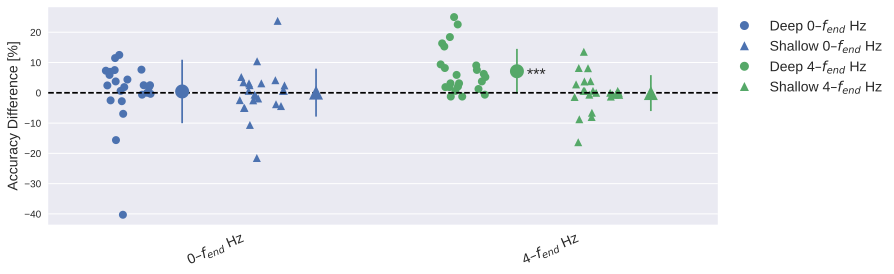

In [84]:
from matplotlib.lines import Line2D
for_eps = False
alpha=0.5
rng = RandomState(39884934)
plt.figure(figsize=(12,4))
rands = rng.randn(23) #rng.randn(len(diffs))
offset = 0
for freq in ('>0', '>4'):
    for net in ('deep5', 'shallow'):
        this_row = df_cnt_epo[(df_cnt_epo.dataset == 'combined') &
                             (df_cnt_epo.freq == freq) &
                             (df_cnt_epo.net == net)]
        label = 'dummy'
        if net == 'deep5':
            marker = 'o'
        else:
            assert net == 'shallow'
            marker = '^'
        if '0-4' == freq:
            color = seaborn.color_palette()[3]
        elif '>0' == freq:
            color = seaborn.color_palette()[0]
        elif '>4' == freq:
            color = seaborn.color_palette()[1]
            
        if for_eps:
            bgcolor = np.array((234/255.0, 234/255.0, 242/255.0))
            small_color = np.array(color) * alpha + ((1-alpha) * bgcolor)
            disp_alpha = 1
        else:
            small_color = color
            disp_alpha = alpha

        cnt_test = this_row['test_cnt_subjects'][0]
        epo_test = this_row['test_epo_subjects'][0]
        diffs = cnt_test - epo_test
        # try plotting ours and bcic with different marker sizes, quite hacky(first 14 shouldbe ours)
        # not doing anymore
        assert clean_trial_sample
        plt.plot(rands[:14] * 0.05 + offset - 0.2,
                diffs[:14], color=small_color, marker=marker, alpha=disp_alpha, linestyle='None',
                markersize=8) #markersize 8
        plt.plot(rands[14:] * 0.05 + offset - 0.2,
                diffs[14:], color=small_color, marker=marker, alpha=disp_alpha, linestyle='None',
                markersize=8)
        plt.errorbar(offset, this_row['diff'][0], color=color,
                     yerr=this_row['std'][0], marker=marker,
                    markersize=14, label=label)

        if this_row['wilc'][0] < 0.05:
            if this_row['wilc'][0] < 0.001:
                signicance_str = '***'
            elif this_row['wilc'][0] < 0.01:
                signicance_str = '**'
            else:
                signicance_str = '*'
            plt.annotate(
                signicance_str, xy=(offset, this_row['diff'][0]), xytext=(10, -4), fontsize=16,
                    textcoords='offset points', ha = 'left', va = 'center',)

        offset += 0.5
    offset += 0.25
plt.axhline(y=0, color='black', linestyle='dashed')
plt.xticks(np.arange(0.125,3,1.25), (u'0–$f_{end}$ Hz', u'4–$f_{end}$ Hz'), rotation=23,
          fontsize=14)
plt.xlim(-0.5,2.)
plt.grid('off', axis='x')
plt.ylabel('Accuracy Difference [%]', fontsize=14)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
# recreate  with empty line, only marker
handles = [Line2D([0], [0], color=h[0].get_color(), marker=h[0].get_marker(),
    markersize=9, linewidth=0) for h in handles]
ax.legend(handles, (u'Deep 0–$f_{end}$ Hz', u'Shallow 0–$f_{end}$ Hz',
                    u'Deep 4–$f_{end}$ Hz', u'Shallow 4–$f_{end}$ Hz'), 
          bbox_to_anchor=(1.,1),
         fontsize=14)

#ax.set_rasterized(True)
plt.savefig('Final_Comparison.ipynb.8.pdf', bbox_inches='tight', dpi=600, pad_inches=0)
plt.savefig('Final_Comparison.ipynb.8.png', bbox_inches='tight', dpi=600, pad_inches=0)
plt.savefig('Final_Comparison.ipynb.8.eps', bbox_inches='tight', dpi=600, pad_inches=0)
None

##### p vals for test

In [61]:
df_cnt_epo[(df_cnt_epo.dataset == 'combined') &
    ((df_cnt_epo.net == 'deep5') |
    (df_cnt_epo.net == 'shallow'))]

,dataset,net,freq,test,diff,std,stderr,test_epo_subjects,test_cnt_subjects,wilc,sign
0,combined,deep5,>0,83.557333,0.436492,10.471114,2.183378,"[97.5, 87.4213836478, 92.5, 78.125, 91.875, 85...","[100.0, 94.3396226415, 92.5, 62.5, 94.375, 93....",0.134134,0.210040
0,combined,shallow,>0,83.134457,0.054974,7.910053,1.649360,"[93.75, 91.1949685535, 93.75, 72.5, 68.125, 92...","[94.375, 86.1635220126, 89.375, 61.875, 91.875...",1.011899,1.000000
0,combined,deep5,>4,75.979115,7.114780,7.381471,1.539143,"[99.375, 86.1635220126, 85.0, 63.75, 92.5, 92....","[98.75, 94.3396226415, 88.75, 62.5, 93.75, 94....",0.000008,0.000488
0,combined,shallow,>4,85.337424,-0.094738,5.931922,1.236891,"[99.375, 87.4213836478, 95.0, 62.5, 97.5, 97.5...","[99.375, 95.5974842767, 94.375, 63.125, 96.875...",0.988101,1.000000


In [62]:
df_cnt_epo.to_csv('data/paper/p-values/df_cnt_epo.csv')

### Modification Experiments

In [63]:
clean_mod_compare = True
df_mod = pd.DataFrame()
shallow_variants = [
                   ('No Dropout', lambda df: no_drop(yes_bnorm(df))),
                   ('No Batch Norm', lambda df: yes_drop(no_bnorm(df))),
                   ('No Dropout No Batch Norm', lambda df: no_drop(no_bnorm(df))),
                   ('No Split 1st Layer', no_split_first_layer),
                   ('No Tied Loss', no_tied_loss),
                   ('Sqrt instead of log', square_mean_sqrt),
                   ('Elu Max', elu_max_shallow),
                   ('Elu Mean', elu_mean_shallow),]

deep_variants = [
                   ('No Dropout', lambda df: tied_loss(no_drop(yes_bnorm(df)))),
                   ('No Batch Norm', lambda df: tied_loss(split_first_layer(yes_drop(no_bnorm(df))))),
                   ('No Dropout No Batch Norm', lambda df: tied_loss(
                        single_time_convs(elu_nonlins(no_drop(no_bnorm(df)))))),
                   ('No Split 1st Layer', no_split_first_layer),
                   ('No Tied Loss', lambda df: no_tied_loss(
                        single_time_convs(yes_drop(yes_bnorm(elu_nonlins(df)))))),
                   ('ReLU', lambda df: relu_nonlins(yes_bnorm(df))),
                   ('Log(Mean(Square)) first', square_mean_first),
                   ('Log(Max(Square)) first', square_max_first),
                   ('6x1+6x1 convs', double_time_convs),]

for dataset in 'bcic', 'ours', 'combined':
    for net in 'shallow', 'deep5':
        if net == 'shallow':
            variants = shallow_variants
        else:
            assert net == 'deep5'
            variants = deep_variants
        if dataset == 'bcic' and net == 'shallow':
            df_compare = df_shallow_cnt_bcic
        elif dataset == 'bcic' and net == 'deep5':
            df_compare = df_deep_cnt_bcic
        elif dataset == 'ours' and net == 'shallow':
            df_compare = df_shallow_cnt_ours
        elif dataset == 'ours' and net == 'deep5':
            df_compare = df_deep_cnt_ours
        elif dataset == 'combined' and net == 'shallow':
            df_compare = (df_shallow_cnt_bcic, df_shallow_cnt_ours)
        elif dataset == 'combined' and net == 'deep5':
            df_compare = (df_deep_cnt_bcic, df_deep_cnt_ours)
        else:
            raise ValueError("unknown combination")
            
        if clean_mod_compare:
            if dataset != 'combined':
                df_compare = clean_datasets(df_compare)
            else:
                assert dataset == 'combined'
                df_compare = [clean_datasets(df_set) for df_set in df_compare]
        if dataset != 'combined':
            df_compare = df_compare[df_compare.max_increasing_epochs == 80]
        else:
            assert dataset == 'combined'
            df_compare = [df_set[df_set.max_increasing_epochs == 80] for df_set in df_compare]
            
        for freq in '>0', '>4':
            if dataset in ('bcic', 'ours'):
                df_baseline = all_df[(all_df.net == net)&
                                    (all_df.freq == freq) &
                                    (all_df.dataset == dataset) &
                                    (all_df.train_type == 'cnt') &
                                    (all_df.clean == clean_mod_compare)]
            else:
                df_baseline =  all_df[(all_df.net == net)&
                                    (all_df.freq == freq) &
                                    (all_df.train_type == 'cnt') &
                                    (all_df.clean == clean_mod_compare)]
                
            # new, if needed
            #df_compare = restrict_or_missing_col(df_compare, max_abs_threshold=800)
            for var_name, var_func in variants:
                if freq == '>0' and dataset in ('bcic', 'ours'):
                    df_var = var_func(above_0(df_compare))
                elif dataset in ('bcic', 'ours'):
                    assert freq == '>4'
                    df_var = var_func(above_4(df_compare))
                elif freq == '>0' and dataset == 'combined':
                    df_var_1 = var_func(above_0(df_compare[0]))
                    df_var_2 = var_func(above_0(df_compare[1]))
                    df_var = pd.concat((df_var_1, df_var_2))
                elif freq == '>4' and dataset == 'combined':
                    df_var_1 = var_func(above_4(df_compare[0]))
                    df_var_2 = var_func(above_4(df_compare[1]))
                    df_var = pd.concat((df_var_1, df_var_2))
                if var_name != 'No Tied Loss':
                    df_var = tied_loss(df_var)
                if dataset == 'bcic':
                    assert len(df_var) == 9
                elif dataset == 'ours':
                    assert len(df_var) == 20 or (len(df_var) == 14 and clean_mod_compare)
                else:
                    assert dataset == 'combined'
                    assert len(df_var) == 29 or (len(df_var) == 23 and clean_mod_compare)
                assert len(df_var) == len(df_baseline), (
                    "Expect length of variant {:d} to be same as length of baseline {:d}".format(
                    len(df_var), len(df_baseline)))
                df_merged = df_baseline.merge(df_var, on='dataset_filename', suffixes=('_base','_var'))
                # not really necessary to sort, just to make sure 
                df_merged = df_merged.sort_values(by='dataset_filename')
                test_baseline = np.array(df_merged.test_base)
                test_variant = np.array(df_merged.test_var)
                this_df_mod = pd.DataFrame()
                this_df_mod['dataset'] = [dataset]
                this_df_mod['net'] = [net]
                this_df_mod['freq'] = [freq]
                this_df_mod['variant'] = [var_name]
                this_df_mod['test'] = [np.mean(df_merged.test_var)]
                this_df_mod['diff'] = [np.mean(df_merged.test_var - df_merged.test_base)]
                this_df_mod['std'] = [np.std(df_merged.test_var - df_merged.test_base)]
                this_df_mod['stderr'] = [np.std(df_merged.test_var - df_merged.test_base) / 
                                         np.sqrt(len(df_merged))]
                this_df_mod['test_baseline_subjects'] = [test_baseline]
                this_df_mod['test_variant_subjects'] = [test_variant]
                
                add_p_vals_to_df_row(this_df_mod, test_variant, 
                                     test_baseline, n_diffs_for_large=2**17)
                df_mod = pd.concat((df_mod, this_df_mod))

In [64]:
df_mod.to_csv('data/paper/p-values/df_mod.csv')

In [65]:
common_variants = np.intersect1d(zip(*deep_variants)[0], zip(*shallow_variants)[0])

other_shallow_vars = np.setdiff1d(zip(*shallow_variants)[0], zip(*deep_variants)[0])[::-1]
other_deep_vars = np.setdiff1d(zip(*deep_variants)[0], zip(*shallow_variants)[0])[::-1]
all_variants = np.concatenate((common_variants, other_shallow_vars,other_deep_vars))

uncommon_variants = np.concatenate((other_shallow_vars, other_deep_vars))

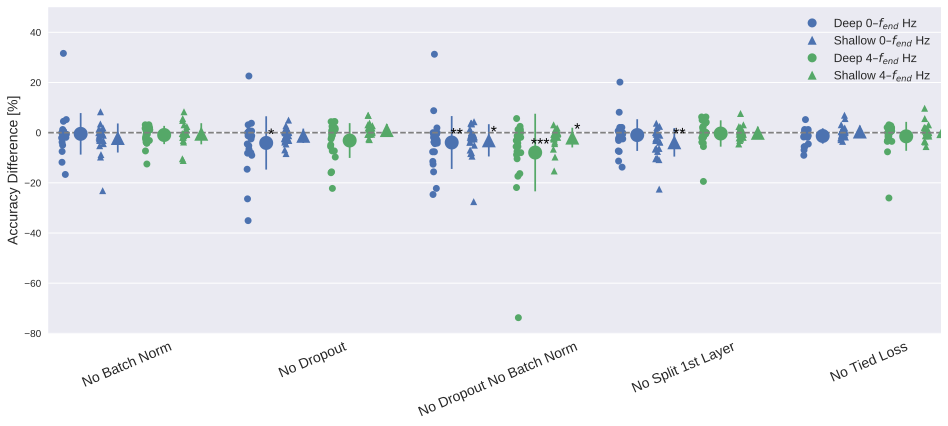

In [66]:
plt.figure(figsize=(16,6))
offset = 0
for_eps = False
alpha=0.55
for i_var, var_name in enumerate(common_variants):
    for freq in [">0", ">4"]:
        for net in 'deep5', 'shallow':
            markersize = 10
            if net == 'deep5':
                marker = 'o'
            else:
                assert net == 'shallow'
                marker = '^'
            if '>0' == freq:
                color = seaborn.color_palette()[0]
            elif '>4' == freq:
                color = seaborn.color_palette()[1]
            this_var = df_mod[(df_mod.variant == var_name) &
                             (df_mod.net == net) & 
                             (df_mod.freq == freq) & 
                             (df_mod.dataset == 'combined')]
            
            baseline_test = this_var.test_baseline_subjects[0]
            var_test = this_var.test_variant_subjects[0]
            diffs = var_test - baseline_test
            assert clean_mod_compare, "Else change logic below with plotting bcic and hgd"
            if for_eps:
                bgcolor = np.array((234/255.0, 234/255.0, 242/255.0))
                small_color = np.array(color) * alpha + ((1-alpha) * bgcolor)
                disp_alpha = 1
            else:
                small_color = color
                disp_alpha = alpha
            # could merge
            plt.plot(rands[:14] * 0.03 + offset - 0.36,
                    diffs[:14], color=small_color, marker=marker, alpha=disp_alpha, linestyle='None',
                    markersize=7) #markersize 8
            plt.plot(rands[14:] * 0.03 + offset - 0.36,
                    diffs[14:], color=small_color, marker=marker, alpha=disp_alpha, linestyle='None',
                    markersize=7)
            plt.errorbar(offset, this_var['diff'][0], color=color,
                         yerr=this_var['std'][0], marker=marker,
                        markersize=14, label='dummy')
            if this_var['wilc'][0] < 0.05:
                significance_str = '*'
                if this_var['wilc'][0] < 0.01:
                    significance_str = '**'
                if this_var['wilc'][0] < 0.001:
                    significance_str = '***'
                plt.annotate(
                        significance_str, xy = (offset, this_var['diff'][0]),
                    xytext = (5, 15), fontsize=16,
                        textcoords = 'offset points', ha = 'center', va = 'top',
                color='black')
            offset += 0.8
        offset += 0.2
    offset += 0.4
#plt.ylim(-20,10)
plt.axhline(y=0, color='grey', linestyle='dashed')

plt.xticks(np.arange(1.,21,4), common_variants, rotation=23, fontsize=14)
plt.grid('off', axis='x')
#plt.xlim(-0.5, plt.xlim()[1]+0.5)
plt.ylabel('Accuracy Difference [%]', fontsize=14)
plt.xlim(-0.7,plt.xlim()[1]-1)
plt.ylim(-80,50)

# get handles
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
# recreate  with empty line, only marker
handles = [Line2D([0], [0], color=h[0].get_color(), marker=h[0].get_marker(),
                 markersize=9, linewidth=0) for h in handles]
# use them in the legend
ax.legend(handles[:4], (u'Deep 0–$f_{end}$ Hz', u'Shallow 0–$f_{end}$ Hz',
                        u'Deep 4–$f_{end}$ Hz',u'Shallow 4–$f_{end}$ Hz'), 
          bbox_to_anchor=(1,1),
         fontsize=12)
plt.savefig('Final_Comparison.ipynb.9.pdf', bbox_inches='tight', dpi=600, pad_inches=0)
plt.savefig('Final_Comparison.ipynb.9.eps', bbox_inches='tight', dpi=600, pad_inches=0)

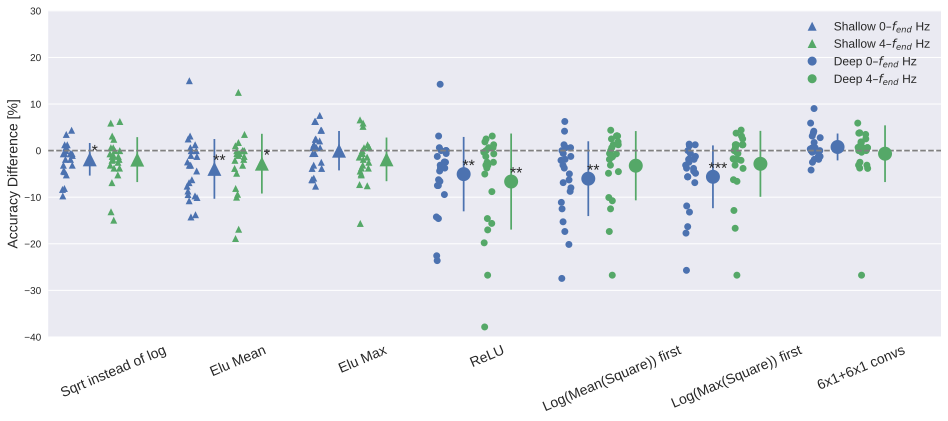

In [67]:
plt.figure(figsize=(16,6))
offset = 0
for_eps = False
alpha=0.55
for i_var, var_name in enumerate(uncommon_variants):
    for freq in [">0", ">4"]:
        for net in 'shallow', 'deep5':
            if net == 'shallow' and var_name in other_deep_vars:
                continue
            if net == 'deep5' and var_name in other_shallow_vars:
                continue
            markersize = 10
            if net == 'deep5':
                marker = 'o'
            else:
                assert net == 'shallow'
                marker = '^'
            if '>0' == freq:
                color = seaborn.color_palette()[0]
            elif '>4' == freq:
                color = seaborn.color_palette()[1]
            this_var = df_mod[(df_mod.variant == var_name) &
                             (df_mod.net == net) & 
                             (df_mod.freq == freq) & 
                             (df_mod.dataset == 'combined')]
            
            baseline_test = this_var.test_baseline_subjects[0]
            var_test = this_var.test_variant_subjects[0]
            diffs = var_test - baseline_test
            assert clean_mod_compare
            if for_eps:
                bgcolor = np.array((234/255.0, 234/255.0, 242/255.0))
                small_color = np.array(color) * alpha + ((1-alpha) * bgcolor)
                disp_alpha = 1
            else:
                small_color = color
                disp_alpha = alpha
            plt.plot(rands[:14] * 0.05 + offset - 0.375,
                    diffs[:14], color=small_color, marker=marker, alpha=disp_alpha, linestyle='None',
                    markersize=7) #markersize 8
            plt.plot(rands[14:] * 0.05 + offset - 0.375,
                    diffs[14:], color=small_color, marker=marker, alpha=disp_alpha, linestyle='None',
                    markersize=7)
            plt.errorbar(offset, this_var['diff'][0], color=color,
                         yerr=this_var['std'][0], marker=marker,
                        markersize=14, label='dummy')
            if this_var['wilc'][0] < 0.05:
                significance_str = '*'
                if this_var['wilc'][0] < 0.01:
                    significance_str = '**'
                if this_var['wilc'][0] < 0.001:
                    significance_str = '***'
                plt.annotate(
                        significance_str, xy = (offset, this_var['diff'][0]),
                    xytext = (5, 15), fontsize=16,
                        textcoords = 'offset points', ha = 'center', va = 'top',)
            offset += 0.6
        offset += 0.2
    offset += 0.5
#plt.ylim(-20,10)
plt.axhline(y=0, color='grey', linestyle='dashed')

plt.xticks(np.arange(0.4,15,2.1), uncommon_variants, rotation=23,
          fontsize=14)
plt.grid('off', axis='x')
plt.xlim(-0.7, plt.xlim()[1]+0.25)
plt.ylabel('Accuracy Difference [%]', fontsize=14)
plt.ylim(-40,30)
# get handles
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
# recreate  with empty line, only marker
handles = [Line2D([0], [0], color=h[0].get_color(), marker=h[0].get_marker(),
                 markersize=9, linewidth=0) for h in handles]
# use them in the legend
ax.legend(handles[:2] + handles[6:8], (u'Shallow 0–$f_{end}$ Hz', u'Shallow 4–$f_{end}$ Hz',
                                       u'Deep 0–$f_{end}$ Hz',u'Deep 4–$f_{end}$ Hz'), 
          bbox_to_anchor=(1.,1),
         fontsize=12)

plt.savefig('Final_Comparison.ipynb.10.pdf', bbox_inches='tight', dpi=600, pad_inches=0)
plt.savefig('Final_Comparison.ipynb.10.eps', bbox_inches='tight', dpi=600, pad_inches=0)

In [85]:
uncommon_variants

array(['Sqrt instead of log', 'Elu Mean', 'Elu Max', 'ReLU',
       'Log(Mean(Square)) first', 'Log(Max(Square)) first', '6x1+6x1 convs'], 
      dtype='|S24')

### Plot for BLBT 2017 Conference

In [86]:
common_variants

array(['No Batch Norm', 'No Dropout', 'No Dropout No Batch Norm',
       'No Split 1st Layer', 'No Tied Loss'], 
      dtype='|S24')

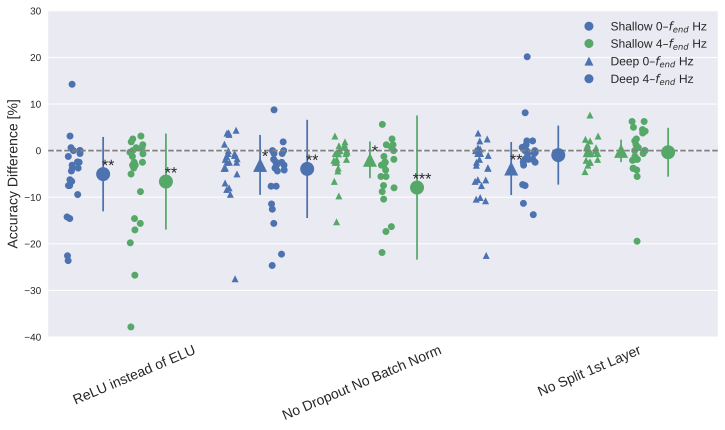

In [98]:
plt.figure(figsize=(12,6))
offset = 0
for_eps = False
alpha=0.55
plot_variants = ('ReLU', 'No Dropout No Batch Norm', 'No Split 1st Layer')
for i_var, var_name in enumerate(plot_variants):
    for freq in [">0", ">4"]:
        for net in 'shallow', 'deep5':
            if net == 'shallow' and var_name in other_deep_vars:
                continue
            if net == 'deep5' and var_name in other_shallow_vars:
                continue
            markersize = 10
            if net == 'deep5':
                marker = 'o'
            else:
                assert net == 'shallow'
                marker = '^'
            if '>0' == freq:
                color = seaborn.color_palette()[0]
            elif '>4' == freq:
                color = seaborn.color_palette()[1]
            this_var = df_mod[(df_mod.variant == var_name) &
                             (df_mod.net == net) & 
                             (df_mod.freq == freq) & 
                             (df_mod.dataset == 'combined')]
            
            baseline_test = this_var.test_baseline_subjects[0]
            var_test = this_var.test_variant_subjects[0]
            diffs = var_test - baseline_test
            assert clean_mod_compare
            if for_eps:
                bgcolor = np.array((234/255.0, 234/255.0, 242/255.0))
                small_color = np.array(color) * alpha + ((1-alpha) * bgcolor)
                disp_alpha = 1
            else:
                small_color = color
                disp_alpha = alpha
            plt.plot(rands[:14] * 0.05 + offset - 0.375,
                    diffs[:14], color=small_color, marker=marker, alpha=disp_alpha, linestyle='None',
                    markersize=7) #markersize 8
            plt.plot(rands[14:] * 0.05 + offset - 0.375,
                    diffs[14:], color=small_color, marker=marker, alpha=disp_alpha, linestyle='None',
                    markersize=7)
            plt.errorbar(offset, this_var['diff'][0], color=color,
                         yerr=this_var['std'][0], marker=marker,
                        markersize=14, label='dummy')
            if this_var['wilc'][0] < 0.05:
                significance_str = '*'
                if this_var['wilc'][0] < 0.01:
                    significance_str = '**'
                if this_var['wilc'][0] < 0.001:
                    significance_str = '***'
                plt.annotate(
                        significance_str, xy = (offset, this_var['diff'][0]),
                    xytext = (5, 15), fontsize=16,
                        textcoords = 'offset points', ha = 'center', va = 'top',)
            offset += 0.6
        offset += 0.2
    offset += 0.4
#plt.ylim(-20,10)
plt.axhline(y=0, color='grey', linestyle='dashed')

plt.xticks([0.4] + np.arange(3.3,9,2.9).tolist(), ('ReLU instead of ELU',) + plot_variants[1:], rotation=23,
          fontsize=14)
plt.grid('off', axis='x')
plt.xlim(-0.7, plt.xlim()[1]+0.25)
plt.ylabel('Accuracy Difference [%]', fontsize=14)
plt.ylim(-40,30)
# get handles
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
# recreate  with empty line, only marker
handles = [Line2D([0], [0], color=h[0].get_color(), marker=h[0].get_marker(),
                 markersize=9, linewidth=0) for h in handles]
# use them in the legend
ax.legend(handles[:2] + handles[6:8], (u'Shallow 0–$f_{end}$ Hz', u'Shallow 4–$f_{end}$ Hz',
                                       u'Deep 0–$f_{end}$ Hz',u'Deep 4–$f_{end}$ Hz'), 
          bbox_to_anchor=(1.,1),
         fontsize=12)

plt.savefig('design_choices.png', bbox_inches='tight', dpi=600, pad_inches=0)


In [95]:
[0.4] + np.arange(3.4,10,3).tolist()

[0.4, 3.4, 6.4, 9.4]

### TODO: significance tied loss for lukas

In [68]:
df_mod.variant.unique()

array(['No Dropout', 'No Batch Norm', 'No Dropout No Batch Norm',
       'No Split 1st Layer', 'No Tied Loss', 'Sqrt instead of log',
       'Elu Max', 'Elu Mean', 'ReLU', 'Log(Mean(Square)) first',
       'Log(Max(Square)) first', '6x1+6x1 convs'], dtype=object)

In [69]:
df_mod[(df_mod.variant == '6x1+6x1 convs') &
      (df_mod.dataset == 'combined')]

,dataset,net,freq,variant,test,diff,std,stderr,test_baseline_subjects,test_variant_subjects,wilc,sign
0,combined,deep5,>0,6x1+6x1 convs,84.769449,0.775624,2.884060,0.601368,"[100.0, 94.3396226415, 92.5, 62.5, 94.375, 93....","[98.75, 94.3396226415, 91.25, 63.125, 92.5, 96...",0.427418,1.00000
0,combined,deep5,>4,6x1+6x1 convs,82.430328,-0.663568,6.085088,1.268829,"[98.75, 94.3396226415, 88.75, 62.5, 93.75, 94....","[99.375, 94.3396226415, 85.625, 63.125, 93.75,...",0.410040,0.21004


## FFT Net

In [70]:
df_deep_epo_fft_bcic = load_data_frame('data/models/paper/bci-competition/epo/deep-fft/', shorten_headers=False)
df_deep_epo_fft_ours = load_data_frame('data/models/paper/ours/epo/deep-fft/', shorten_headers=False)
only_clean_sets = True
if only_clean_sets:
    df_deep_epo_fft_ours = clean_datasets(df_deep_epo_fft_ours)

In [71]:
all_df_fft = pd.DataFrame()
all_df_fft_comp = pd.DataFrame()

dff = df_deep_epo_fft_bcic
main_csp_bcic = restrict_or_unset(csp_above_0(df_csp_bcic), standardize=False,
                                                                   standardize_cnt=False,
                                 trial_start=500)

dff = dff[(dff.num_filters_time == 25) & 
         (dff.preprocessor == 'null') &
         (dff.filter_length_2 == 3) &
         ((dff.layers == 'deep_fft_net_spat_time_freq')) &
         (dff.frequency_end != 36) &
         (dff.frequency_start != 4) &
         (dff.include_phase == False) &
         (dff.square_amplitude == False)]

dff = above_0(dff)

all_df_fft = pd.concat((all_df_fft, dff))

for freq in ['0-40', '0-124']:
    if freq == '0-40':
        this_dfn = dff[dff.frequency_end == 40]
        df_comp = compare_net_csp(this_dfn, main_csp_bcic,
                                  'fft','0-40','bcic',)
    else:
        this_dfn = dff[dff.frequency_end == 'null']
        assert freq == '0-124'
        df_comp = compare_net_csp(this_dfn, main_csp_bcic,
                                  'fft','0-124','bcic')
    all_df_fft_comp = pd.concat((all_df_fft_comp, df_comp))


        
dataset_averaged_frame(remove_columns_with_same_value(dff))

time                    test        train     
                               len    tmean     tstd  mean   std   mean  std
frequency_end frequency_start                                               
40            0                  9 00:02:05 00:00:26  54.6  15.6   99.7  0.7
null          null               9 00:03:17 00:00:36  45.4  14.7  100.0  0.0

In [72]:
dff = df_deep_epo_fft_ours
dff = dff[(dff.include_phase == False) & (dff.square_amplitude == False)]
dataset_averaged_frame(remove_columns_with_same_value(dff))

time                    \
                                                      len    tmean     tstd   
low_cut_hz frequency_end high_cut_hz frequency_start                          
0          40            4           0                 14 00:06:50 00:02:32   
                         null        0                 14 00:05:00 00:01:15   
           null          4           null              14 00:12:42 00:04:22   
                         null        null              14 00:09:39 00:03:10   
4          40            null        0                 14 00:05:21 00:01:22   
           null          null        null              14 00:09:33 00:02:01   

                                                      test       train       
                                                      mean  std   mean  std  
low_cut_hz frequency_end high_cut_hz frequency_start                         
0          40            4           0                79.3  8.8   99.5  1.4  
                         null        0                81.5  8.2   99.5  1.2  
           null          4           null             79.2  9.4   99.0  1.6  
                         null        null             84.5  9.6   99.9  0.5  
4          40            null        0                80.0  9.9   99.9  0.4  
           null          null        null             85.8  9.0  100.0  0.0

In [73]:
dff = df_deep_epo_fft_ours

main_csp_ours = restrict_or_unset(clean_datasets(csp_above_0(df_csp_ours)), standardize=False,
                                                                   standardize_cnt=False,
                                 trial_start=500, max_abs_threshold=800)

dff = dff[(dff.num_filters_time == 25) & 
         (dff.preprocessor == 'null') &
         (dff.filter_length_2 == 3) &
         ((dff.layers == 'deep_fft_net_spat_time_freq') | (dff.layers == 'seperated_linear')) &
         (dff.include_phase == False) &
         (dff.square_amplitude == False)]

dff = above_0(dff)

all_df_fft = pd.concat((all_df_fft, dff))

for freq in ['0-40', '0-124']:
    if freq == '0-40':
        this_dfn = dff[dff.frequency_end == 40]
        df_comp = compare_net_csp(this_dfn, main_csp_ours,
                                  'fft','0-40','ours',)
    else:
        this_dfn = dff[dff.frequency_end == 'null']
        assert freq == '0-124'
        df_comp = compare_net_csp(this_dfn, main_csp_ours,
                                  'fft','0-124','ours')
    all_df_fft_comp = pd.concat((all_df_fft_comp, df_comp))
    
dataset_averaged_frame(remove_columns_with_same_value(dff))

time                    test      train     
                               len    tmean     tstd  mean  std  mean  std
frequency_end frequency_start                                             
40            0                 14 00:05:00 00:01:15  81.5  8.2  99.5  1.2
null          null              14 00:09:39 00:03:10  84.5  9.6  99.9  0.5

#### add combined

In [74]:
for freq in ['0-40', '0-124']:
    if freq == '0-40':
        this_dfn = all_df_fft[all_df_fft.frequency_end == 40]
        df_comp = compare_net_csp(this_dfn, 
                                  csp_above_0(pd.concat((main_csp_ours, main_csp_bcic))),
                                  'fft', '0-40', 'combined',)
    else:
        this_dfn = all_df_fft[all_df_fft.frequency_end == 'null']
        assert freq == '0-124'
        df_comp = compare_net_csp(this_dfn,
                                  csp_above_0(pd.concat((main_csp_ours, main_csp_bcic))),
                                  'fft', '0-124', 'combined')
    all_df_fft_comp = pd.concat((all_df_fft_comp, df_comp))

In [75]:
all_df_fft_comp

,name,freq,dataset,test_net,diff,wilc,sign,time_net
0,fft,0-40,bcic,54.6,-13.3,1.171875e-02,0.039062,00:02:05
0,fft,0-124,bcic,45.4,-22.6,3.906250e-03,0.003906,00:03:17
0,fft,0-40,ours,81.5,-9.6,2.441406e-04,0.001831,00:05:00
0,fft,0-124,ours,84.5,-6.6,3.662109e-04,0.001831,00:09:39
0,fft,0-40,combined,71.0,-11.1,1.668930e-06,0.000066,00:03:52
0,fft,0-124,combined,69.2,-12.9,7.152557e-07,0.000006,00:07:09


In [76]:
remove_columns_with_same_value(dff).iloc[0:2]

,frequency_end,frequency_start,test_filename,dataset_filename,time,test,train
36,40,0,data/BBCI-only-last-runs/BhNoMoSc1S001R13_ds10...,data/BBCI-without-last-runs/BhNoMoSc1S001R01_d...,00:04:45,88.125,100.0
40,null,null,data/BBCI-only-last-runs/BhNoMoSc1S001R13_ds10...,data/BBCI-without-last-runs/BhNoMoSc1S001R01_d...,00:11:33,95.625,100.0


In [77]:
from braindecode.experiments.load import load_exp_and_model
from braindecode.veganlasagne.layer_util import print_layers
_, fft_model = load_exp_and_model('data/models/paper/ours/epo/deep-fft/40')

print_layers(fft_model)

Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
 0-InputLayer                                                         (None, 44, 84, 63)
 1-DropoutLayer             0.000                                    
 2-Conv2DLayer              1x1                                       (None, 25, 84, 63)
 3-Conv2DLayer              3x1                                      
 4-Conv2DLayer              1x63                                      (None, 25, 84, 1)
 5-BatchNormLayer                                     elu            
 6-Pool2DLayer              3x1 ::3 ::3               max             (None, 25, 28, 1)
 7-NonlinearityLayer                                                 
 8-DropoutLayer             0.500                                    
 9-Conv2DLayer              3x1                                       (None, 50, 28, 1)
10-BatchNormLayer                                     elu            
11-Pool2DLayer              3x

In [78]:
import lasagne
lasagne.layers.get_all_layers(fft_model)[3].pad

(1, 0)

### Residual Net

In [79]:
from braindecode.experiments.load import load_exp_and_model
exp, model = load_exp_and_model('data/models/paper/ours/cnt/resnet/2')

INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 424
INFO:braindecode.experiments.experiment:Input window length is 577


Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer
Correcting for old batch norm layer


INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 424
INFO:braindecode.experiments.experiment:Input window length is 577


In [80]:
from braindecode.veganlasagne.layers import get_n_sample_preds

In [81]:
df_resnet_bcic = load_data_frame('data/models/paper/bci-competition/cnt/resnet/', params=dict(whisker_percent=None),
                            shorten_headers=False)
assert np.all(df_resnet_bcic.max_abs_threshold == 800)
assert np.all(df_resnet_bcic.trial_start == 1500)
df_resnet_bcic = df_resnet_bcic[df_resnet_bcic.loss_expression == 'tied_neighbours_decay']
averaged_frame = dataset_averaged_frame(remove_columns_with_same_value(df_resnet_bcic))
averaged_frame

time                    test        train     
            len    tmean     tstd  mean   std   mean  std
low_cut_hz                                               
0             9 01:21:21 00:18:05  67.7  12.9  100.0  0.0
4             9 01:13:20 00:07:36  60.8  17.5  100.0  0.1

In [82]:
dataset_averaged_frame(remove_columns_with_same_value(clean_datasets(df_resnet_ours_old)))

NameError: name 'df_resnet_ours_old' is not defined

##### comparisons to deep5

In [ ]:
def no_bp_meaner(df):
    return df[df.batch_modifier != 'bp_meaner']

In [ ]:
clean_resnet = True
df_resnet_ours = load_data_frame('data/models/paper/ours/cnt/resnet/', params=dict(whisker_percent=None),
                            shorten_headers=False)
df_resnet_ours = df_resnet_ours[df_resnet_ours.loss_expression == 'tied_neighbours_decay']
assert np.all(df_resnet_ours.max_abs_threshold == 800)
assert np.all(df_resnet_ours.trial_start == 1500)
if clean_resnet:
    df_resnet_ours = clean_datasets(df_resnet_ours)

averaged_frame = dataset_averaged_frame(remove_columns_with_same_value(df_resnet_ours))
averaged_frame

In [ ]:
df_resnet_row = compare_net_csp(above_0(df_resnet_bcic),
                all_df[(all_df.dataset == 'bcic') & (all_df.clean ==True) &
                       (all_df.net == 'deep5') & (all_df.train_type == 'cnt') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == -500) &
                             (all_df.freq == ">0")], 
                'resnet','>0','bcic')
df_resnet_vs_deep = df_resnet_row

df_resnet_vs_deep = df_resnet_vs_deep.append(compare_net_csp(above_4(df_resnet_bcic),
                all_df[(all_df.dataset == 'bcic') & (all_df.clean ==True) &
                       (all_df.net == 'deep5') & (all_df.train_type == 'cnt') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == -500) &
                             (all_df.freq == ">4")], 
                'resnet','>4','bcic'))

df_resnet_vs_deep = df_resnet_vs_deep.append(compare_net_csp(above_0(df_resnet_ours),
                all_df[(all_df.dataset == 'ours') & (all_df.clean ==True) &
                       (all_df.net == 'deep5') & (all_df.train_type == 'cnt') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == -500) &
                             (all_df.freq == ">0")],
                'resnet','>0','ours'))

df_resnet_vs_deep = df_resnet_vs_deep.append(compare_net_csp(above_4(df_resnet_ours),
                all_df[(all_df.dataset == 'ours') & (all_df.clean ==True) &
                       (all_df.net == 'deep5') & (all_df.train_type == 'cnt') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == -500) &
                             (all_df.freq == ">4")],
                'resnet','>4','ours'))

df_resnet_vs_deep

df_resnet_vs_deep = df_resnet_vs_deep.append(compare_net_csp(pd.concat((above_0(df_resnet_bcic), above_0(df_resnet_ours))),
                pd.concat((all_df[(all_df.dataset == 'bcic') & (all_df.clean ==True) &
                       (all_df.net == 'deep5') & (all_df.train_type == 'cnt') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == -500) &
                             (all_df.freq == ">0")],
            all_df[(all_df.dataset == 'ours') & (all_df.clean ==True) &
                       (all_df.net == 'deep5') & (all_df.train_type == 'cnt') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == -500) &
                             (all_df.freq == ">0")])),
                'resnet','>0','combined', max_n_p_vals=3))

df_resnet_vs_deep = df_resnet_vs_deep.append(compare_net_csp(pd.concat((above_4(df_resnet_bcic), above_4(df_resnet_ours))),
                pd.concat((all_df[(all_df.dataset == 'bcic') & (all_df.clean ==True) &
                       (all_df.net == 'deep5') & (all_df.train_type == 'cnt') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == -500) &
                             (all_df.freq == ">0")],
            all_df[(all_df.dataset == 'ours') & (all_df.clean ==True) &
                       (all_df.net == 'deep5') & (all_df.train_type == 'cnt') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == -500) &
                             (all_df.freq == ">4")])),
                'resnet','>4','combined', max_n_p_vals=3))
df_resnet_vs_deep

In [ ]:
df_resnet_vs_deep.to_csv('data/paper/p-values/df_resnet_vs_deep.csv')

### comparisons to csp

In [ ]:
df_resnet_vs_csp = compare_net_csp(above_0(df_resnet_bcic),
                all_df[(all_df.dataset == 'bcic') & (all_df.clean ==True) &
                       (all_df.net == 'csp') & (all_df.train_type == 'epo') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == 500) &
                             (all_df.freq == ">0")], 
                'resnet','>0','bcic')

df_resnet_vs_csp = df_resnet_vs_csp.append(compare_net_csp(above_4(df_resnet_bcic),
                all_df[(all_df.dataset == 'bcic') & (all_df.clean ==True) &
                       (all_df.net == 'csp') & (all_df.train_type == 'epo') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == 500) &
                             (all_df.freq == ">4")], 
                'resnet','>4','bcic'))

df_resnet_vs_csp = df_resnet_vs_csp.append(compare_net_csp(above_0(df_resnet_ours),
                all_df[(all_df.dataset == 'ours') & (all_df.clean ==True) &
                       (all_df.net == 'csp') & (all_df.train_type == 'epo') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == 500) &
                             (all_df.freq == ">0")], 
                'resnet','>0','ours'))

df_resnet_vs_csp = df_resnet_vs_csp.append(compare_net_csp(above_4(df_resnet_ours),
                all_df[(all_df.dataset == 'ours') & (all_df.clean ==True) &
                       (all_df.net == 'csp') & (all_df.train_type == 'epo') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == 500) &
                             (all_df.freq == ">4")], 
                'resnet','>4','ours'))

df_resnet_vs_csp = df_resnet_vs_csp.append(compare_net_csp(pd.concat((above_0(df_resnet_bcic), above_0(df_resnet_ours))),
                pd.concat((all_df[(all_df.dataset == 'bcic') & (all_df.clean ==True) &
                       (all_df.net == 'csp') & (all_df.train_type == 'epo') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == 500) &
                             (all_df.freq == ">0")],
            all_df[(all_df.dataset == 'ours') & (all_df.clean ==True) &
                       (all_df.net == 'csp') & (all_df.train_type == 'epo') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == 500) &
                             (all_df.freq == ">0")])),
                'resnet','>0','combined', max_n_p_vals=3))

df_resnet_vs_csp = df_resnet_vs_csp.append(compare_net_csp(pd.concat((above_4(df_resnet_bcic), above_4(df_resnet_ours))),
                pd.concat((all_df[(all_df.dataset == 'bcic') & (all_df.clean ==True) &
                       (all_df.net == 'csp') & (all_df.train_type == 'epo') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == 500) &
                             (all_df.freq == ">0")],
            all_df[(all_df.dataset == 'ours') & (all_df.clean ==True) &
                       (all_df.net == 'csp') & (all_df.train_type == 'epo') &
                             (all_df.max_abs_threshold == 800) &
                             (all_df.trial_start == 500) &
                             (all_df.freq == ">4")])),
                'resnet','>4','combined', max_n_p_vals=3))

In [ ]:
df_resnet_vs_csp.to_csv('data/paper/p-values/df_resnet_vs_csp.csv')

#### individual subjects - still needed?

In [ ]:
remove_columns_with_same_value(df_resnet_ours[(df_resnet_ours.loss_expression == 'tied_neighbours_decay') & 
                                             (df_resnet_ours.low_cut_hz == 0)])

### Training TImes

In [ ]:

df_csp_ours = load_data_frame('data/models/paper/ours/csp/', shorten_headers=False)
df_csp_bcic = load_data_frame('data/models/paper/bci-competition/csp/', shorten_headers=False)

In [ ]:
from IPython.display import display_html, display, HTML
from braindecode.analysis.pandas_util import dataset_averaged_frame, remove_columns_with_same_value, load_data_frame

In [ ]:
def display_bci_competition_times(folder):
    display(HTML("<h5>Shallow</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/bci-competition/cnt/shallow/{:s}/'.format(folder),
                                  shorten_headers=False)))))
    display(HTML("<h5>Deep</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/bci-competition/cnt/deep4/{:s}/'.format(folder),
                                  shorten_headers=False)))))
    
def display_ours_times(folder):
    display(HTML("<h5>Shallow</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/ours-before-cz-0/cnt/shallow/{:s}/'.format(folder),
                                  shorten_headers=False)))))
    display(HTML("<h5>Deep</h5>"))
    display_html(dataset_averaged_frame(remove_columns_with_same_value(
        clean_datasets(load_data_frame('data/models/paper/ours-before-cz-0/cnt/deep4/{:s}/'.format(folder),
                                  shorten_headers=False)))))

#### BCI Competition

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(csp_above_0(df_csp_bcic)))

In [ ]:
display_bci_competition_times('traintime-rz')

In [ ]:
display_bci_competition_times('traintime-tf')

#### Ours

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(csp_above_0(df_csp_ours)))

In [ ]:
dataset_averaged_frame(all_df[(all_df.dataset =='ours') &
                             (all_df.clean == False)
                             ])

In [ ]:
display_ours_times('traintime-rz')

In [ ]:
display_ours_times('traintime-tf')

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(
    clean_datasets(load_data_frame('data/models/paper/ours/cnt/shallow/traintime-rz/',
                                  shorten_headers=False))))

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(
    clean_datasets(load_data_frame('data/models/paper/ours/cnt/deep4/traintime-rz/',
                                  shorten_headers=False))))

### Old trianing times, unclear which queue

In [ ]:
dfn = restrict(shallow_cnt_default(tied_loss(above_0(square_shallow(df_shallow_cnt_bcic)))), drop_p='-')
dataset_averaged_frame(remove_columns_with_same_value(dfn))

In [ ]:
dfn = no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_bcic)))))
dataset_averaged_frame(remove_columns_with_same_value(dfn))

In [ ]:
dfn = restrict(shallow_cnt_default(tied_loss(above_0(square_shallow(df_shallow_cnt_ours)))), drop_p='-', tag='repl')
dataset_averaged_frame(remove_columns_with_same_value(dfn))

In [ ]:
dfn = no_bp_meaner(tied_loss(deep_5_new_default(above_0(elu_deep_5(df_deep_cnt_ours)))))
dataset_averaged_frame(remove_columns_with_same_value(dfn))

### New ours Run

In [ ]:
remove_columns_with_same_value(load_data_frame('data/models/paper/ours-before-cz-0/csp/car/'))

In [ ]:
df_deep_ours_new = load_data_frame('data/models/paper/ours/cnt/deep5/', shorten_headers=False)

In [ ]:
avgd = dataset_averaged_frame(remove_columns_with_same_value(df_deep_ours_new))

In [ ]:
df_shallow_ours_new = load_data_frame('data/models/paper/ours/cnt/shallow/', shorten_headers=False)

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(df_shallow_ours_new))

In [ ]:
def strfdelta(tdelta, fmt):
    """For numpy timedelta, modified from
    http://stackoverflow.com/a/8907269/1469195"""
    d = {"days": tdelta.astype('timedelta64[D]').astype(np.int32)}
    # only those seconds not absorbed by day
    seconds = tdelta.astype('timedelta64[s]').astype(np.int32) % (3600 * 24)
   
    d["hours"], rem = divmod(seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

In [ ]:
time_lens = np.array(avgd['time', 'len'])
time_means = np.array(avgd['time', 'tmean'])

n_open_exps_per_variant = 20 - time_lens
n_open_exps = np.sum(n_open_exps_per_variant)
remaining_time_per_variant = n_open_exps_per_variant * time_means

avg_time_per_exp = np.sum(time_means * time_lens) / float(np.sum(time_lens))
total_time = n_open_exps * avg_time_per_exp
print strfdelta(np.sum(remaining_time_per_variant) / 14.0, "{days} days {hours}:{minutes}:{seconds}")

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(load_data_frame('data/models/paper/ours/epo/shallow//')))

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(load_data_frame('data/models/paper/ours/epo/deep4/')))

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(df_csp_ours))

In [ ]:
df_shallow_wanted = tied_loss(square_shallow(shallow_cnt_default(yes_drop(yes_bnorm(above_4(df_clean))))))

In [ ]:
df_shallow_wanted = remove_columns_with_same_value(df_shallow_wanted)

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(df_shallow_wanted))

In [ ]:
df_csp_wanted = remove_columns_with_same_value(csp_above_4(df_csp_ours_clean))

In [ ]:
dataset_averaged_frame(df_csp_wanted)

In [ ]:
compare_net_csp(df_shallow_wanted, df_csp_wanted,'shallow', '4', 'ours',with_csp_acc=True,with_std=True,
               with_std_error=True)

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(df_csp_ours_clean))

In [ ]:
df_clean = df_shallow_ours_new.copy()
df_csp_ours_clean = df_csp_ours.copy
for name in unclean_sets:
    df_clean = df_clean[np.logical_not(df_clean.dataset_filename.str.contains(name))]
    df_csp_ours_clean = df_csp_ours_clean[np.logical_not(df_csp_ours_clean.dataset_filename.str.contains(name))]
dataset_averaged_frame(remove_columns_with_same_value(df_clean))
    

In [ ]:

df_csp_ours = load_data_frame('data/models/paper/ours/csp/', shorten_headers=False)

In [ ]:
dataset_averaged_frame(remove_columns_with_same_value(df_csp_ours))

In [ ]:
df_clean_csp = df_csp_ours.copy()
for name in unclean_sets:
    df_clean_csp = df_clean_csp[np.logical_not(df_clean_csp.dataset_filename.str.contains(name))]
dataset_averaged_frame(remove_columns_with_same_value(df_clean_csp))
    

### Compare with more epochs

In [ ]:
param_keys

In [ ]:
df_ours = df_shallow_cnt_ours

param_keys = df_ours.columns

param_keys = set(param_keys) - set(['test', 'train', 'time', 'max_epochs', 'max_increasing_epochs'])

df_long = df_ours[df_ours.max_increasing_epochs == 160]
df_quick = df_ours[df_ours.max_increasing_epochs == 80]

df_merged = df_long.merge(df_quick, on=list(param_keys), suffixes=('_long', '_quick'))

plt.plot(df_merged.test_long - df_merged.test_quick)
plt.axhline(y=0, color='k')
print np.mean(df_merged.test_long - df_merged.test_quick)

In [ ]:
df_ours = df_deep_cnt_ours

param_keys = df_ours.columns

param_keys = set(param_keys) - set(['test', 'train', 'time', 'max_epochs', 'max_increasing_epochs'])

df_long = df_ours[df_ours.max_increasing_epochs == 160]
df_quick = df_ours[df_ours.max_increasing_epochs == 80]

df_merged = df_long.merge(df_quick, on=list(param_keys), suffixes=('_long', '_quick'))

plt.plot(df_merged.test_long - df_merged.test_quick)
plt.axhline(y=0, color='k')
print np.mean(df_merged.test_long - df_merged.test_quick)

### Vs different trials

In [ ]:
df_ours = df_shallow_cnt_ours

param_keys = df_ours.columns

param_keys = set(param_keys) - set(['test', 'train', 'time', 'max_epochs', 'max_increasing_epochs', 'trial_start'])

df_long = df_ours[df_ours.trial_start == 2000]
df_quick = df_ours[df_ours.max_increasing_epochs == 80]

df_merged = df_long.merge(df_quick, on=list(param_keys), suffixes=('_long', '_quick'))

plt.plot(df_merged.test_long - df_merged.test_quick)
plt.axhline(y=0, color='k')
print np.mean(df_merged.test_long - df_merged.test_quick)

In [ ]:
df_ours = df_deep_cnt_ours

param_keys = df_ours.columns

param_keys = set(param_keys) - set(['test', 'train', 'time', 'max_epochs', 'max_increasing_epochs', 'trial_start'])

df_long = df_ours[df_ours.trial_start == 2000]
df_quick = df_ours[df_ours.max_increasing_epochs == 80]

df_merged = df_long.merge(df_quick, on=list(param_keys), suffixes=('_long', '_quick'))

plt.plot(df_merged.test_long - df_merged.test_quick)
plt.axhline(y=0, color='k')
print np.mean(df_merged.test_long - df_merged.test_quick)

### BCI competition CSP with >0 Hz

In [ ]:

df_csp_bcic = load_data_frame('data/models/paper/bci-competition/csp/', shorten_headers=False)

In [ ]:
dfc = df_csp_bcic
dfc = dfc[dfc.min_freq == 1.0]
dataset_averaged_frame(remove_columns_with_same_value(dfc)).sort_values(('test', 'mean'),ascending=False)

In [ ]:

df_csp_ours = load_data_frame('data/models/paper/ours/csp/', shorten_headers=False)

In [ ]:
dfc = df_csp_ours
dfc = dfc[dfc.min_freq == 1.0]
dataset_averaged_frame(remove_columns_with_same_value(dfc)).sort_values(('test', 'mean'),ascending=False)